Instructions on running the ipynb file on your computer:
1. Upload the remote_sensing_ran directory with the file it contains into the MyDrive directory.
2. Change the ee authentication username
3. Run the code, you may need to restart the session and run again after packages installation.

### Installing & Importing Packages

In [1]:
# Install these packages in Google Colab:
# !pip uninstall -y numpy pandas rioxarray rasterio shapely
!pip install numpy==1.25.2
!pip install pandas
!pip install rioxarray
!pip install rasterio
!pip install shapely
!pip install cartopy
!pip install rioxarray
!pip install geopandas
!pip install pycrs

  Preparing metadata (setup.py) ... done
  Created wheel for pycrs: filename=PyCRS-1.0.2-py3-none-any.whl size=32686 sha256=d6fd66b024d0426ae96766ced9fc02280776e7ce6e729c700657872c8e8e56f7
  Stored in directory: /root/.cache/pip/wheels/47/1d/70/7a5bdf33347e7c75e95b06b1fa38f076a59a9506653cc24aff
Successfully built pycrs


In [2]:
# 1_Import important Packages
import os
import warnings

import rioxarray
import matplotlib.pyplot as plt
import numpy.ma as ma
import pandas as pd
import xarray as xr
import seaborn as sns
import rioxarray as rio
from shapely.geometry import mapping, box
import rasterio
from rasterio.plot import show
warnings.simplefilter('ignore')
import math
import numpy as np
import sklearn.metrics as metrics
from osgeo import gdal, gdalconst
from matplotlib import ticker
import cartopy.crs as ccrs
import cartopy

In [3]:
# creating the necessery dirs for the project in google drive.

try:

  !mkdir '/content/drive/MyDrive/remote_sensing_ran/clipped'
  !mkdir '/content/drive/MyDrive/remote_sensing_ran/resampled'
  !mkdir '/content/drive/MyDrive/remote_sensing_ran/output_plots'
  !mkdir '/content/drive/MyDrive/remote_sensing_ran/output_plots/after_cleaning'

except:
  pass

path = '/content/drive/MyDrive/remote_sensing_ran/'


In [4]:
# 2_Import GEE for python and get into your account
import ee

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='ee-ranavner5')

### Classes

In [5]:
class Raster_MOD: # defining a class with each raster's data and bounds
  def __init__(self, fname):
    self.fname = fname
    self.raster_ = rasterio.open('/content/drive/MyDrive/remote_sensing_ran/' + fname)
    self.minx, self.miny,  = self.raster_.bounds[0], self.raster_.bounds[1]
    self.maxx, self.maxy = self.raster_.bounds[2], self.raster_.bounds[3]
    self.bbox = box(self.minx, self.miny, self.maxx, self.maxy)

  def show_mod(self):
    self.raster_MOD = rasterio.open('/content/drive/MyDrive/remote_sensing_ran/' + self.fname)
    show((self.raster_MOD, 1))

In [6]:
class Raster_WAVE: # defining a class with each raster's data and bounds
  def __init__(self, fname):
    self.fname = fname
    self.rds = rio.open_rasterio(('/content/drive/MyDrive/remote_sensing_ran/' + self.fname), decode_times=False) # Read SAF NetCDF file
    self.SAF_file = self.fname
    print(self.SAF_file)
    self.SAF_name = self.SAF_file[:-3]
    print(self.SAF_name)
    self.dset_w84 = self.rds.rio.reproject("EPSG:4326")# reproject to WG84

    if 'LW' in self.SAF_file:
      self.dset_w84["DSLF"].rio.to_raster('SAF.tif') # select LST band
      self.raster_ = rasterio.open('SAF.tif')
      array = self.raster_.read(1)
    if 'SW' in self.SAF_file:
      self.dset_w84["DSSF_TOT"].rio.to_raster('SAF.tif') # select LST band
      self.raster_ = rasterio.open('SAF.tif')

  def show_WAVE(self):
    show((self.raster_, 1))

### Functions

In [7]:
def implement_geodataframe(coords, target):
  # Now we are ready to clip the raster with the polygon using the coords
  # variable that we just created. Clipping the raster can be done easily with
  # the mask function that we imported from rasterio, and specifying clip=True.

  from rasterio.mask import mask
  out_img, out_transform = mask(target.raster_, shapes=coords, crop=True)
  out_img[out_img<0] = 0
  # Next, we need to modify the metadata.
  # Let’s start by copying the metadata from the original data file.
  out_meta = target.raster_.meta.copy()
  print(out_meta)

  # Next we need to parse the EPSG value from the CRS so that we can create a
  # Proj4 string using PyCRS library (to ensure that the projection information
  # is saved correctly).
  epsg_code = int(target.raster_.crs.data['init'][5:])
  print(epsg_code)

  # Now we need to update the metadata with new dimensions, transform (affine)
  # and CRS (as Proj4 text)
  import pycrs
  out_meta.update({"driver": "GTiff","height": out_img.shape[1],
                  "width": out_img.shape[2],
                  'dtype': 'float64',
                  "transform": out_transform,
                  "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()})

  # Finally, we can save the clipped raster to disk with following command
  out_tif = path + 'clipped/' + 'Clipped_' + target.fname  # shortwave radiation clipped!!!
  print(out_tif)
  with rasterio.open(out_tif, "w", **out_meta) as dest:
    dest.write(out_img)

  # Let’s check that the result is correct by plotting our new clipped raster
  clipped_raster = rasterio.open(out_tif)
  array = clipped_raster.read(1)
  show((clipped_raster, 1), cmap='terrain')
  print(clipped_raster.shape)


In [8]:
def resample(input_file, ref_file, output_name, path=path):
  # 9a_We need to resample one of the images to the spatial resolution of the
  # other. Let's resample WRF 2-km to the 1-km resolution of MODIS

  from osgeo import gdal, gdalconst

  # The tile needed to be resampled to the new resolution
  inputfile  = path + input_file
  print(inputfile)
  input      = gdal.Open(inputfile, gdalconst.GA_ReadOnly)
  inputProj  = input.GetProjection()
  inputTrans = input.GetGeoTransform()

  # The refernce file for resampling
  referencefile = path + ref_file
  reference = gdal.Open(referencefile, gdalconst.GA_ReadOnly)
  referenceProj = reference.GetProjection()
  referenceTrans = reference.GetGeoTransform()
  bandreference = reference.GetRasterBand(1)
  x = reference.RasterXSize
  y = reference.RasterYSize

  # The output resampled file (WRF to 1 km)
  outputfile = path + output_name + '.tif'
  driver= gdal.GetDriverByName('GTiff')
  output = driver.Create(outputfile,x,y,1,bandreference.DataType)
  output.SetGeoTransform(referenceTrans)
  output.SetProjection(referenceProj)

  gdal.ReprojectImage(input,output,inputProj,referenceProj,gdalconst.GRA_Bilinear)

  del output

  resm_input = rasterio.open(outputfile)

  return resm_input

In [9]:
def raster_to_array(raster_file, scale_factor):

  raster_array                  = xr.open_dataset(path + raster_file, engine='rasterio')
  raster_array                  = raster_array * scale_factor

  return raster_array

In [10]:
def present_rasters(name, raster1, raster2, vmin, vmax, units):

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), subplot_kw={'projection': ccrs.Robinson()})

  # Plot for 03
  ax1.coastlines()
  ax1.add_feature(cartopy.feature.OCEAN, alpha=1.0)
  ax1.add_feature(cartopy.feature.LAKES, alpha=1.0)
  ax1.add_feature(cartopy.feature.RIVERS)
  p1 = raster2['band_data'].plot(ax=ax1, levels=15, vmin=vmin, vmax=vmax, cmap='Spectral_r', transform=ccrs.PlateCarree(), add_colorbar=False)
  ax1.set_title(f'{name} at 22/03/2018')
  gl1 = ax1.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
  gl1.top_labels = False
  gl1.right_labels = False

  # Plot for 08
  ax2.coastlines()
  ax2.add_feature(cartopy.feature.OCEAN, alpha=1.0)
  ax2.add_feature(cartopy.feature.LAKES, alpha=1.0)
  ax2.add_feature(cartopy.feature.RIVERS)
  p2 = raster1['band_data'].plot(ax=ax2, levels=15, vmin=vmin, vmax=vmax, cmap='Spectral_r', transform=ccrs.PlateCarree(), add_colorbar=False)
  ax2.set_title(f'{name} at 24/08/2018')
  gl2 = ax2.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
  gl2.top_labels = False
  gl2.right_labels = False

  # Adjust color bar axis
  cax = fig.add_axes([0.325, -0.03, 0.4, 0.02])
  tick_locator = ticker.MaxNLocator(nbins=8)
  cb = fig.colorbar(p1, cax=cax, orientation='horizontal')
  cb.locator = tick_locator
  cb.update_ticks()
  cb.ax.set_xlabel(f'{name} {units}')

  plt.savefig(path + 'output_plots/' + name + '_rasters.png', bbox_inches='tight')

  plt.show()

In [11]:
def calc_stats(raster1, raster2, name):
  # raster1
  raster1 = raster1['band_data']
  mean1 = raster1.mean(skipna=True).item()
  median1 = raster1.median().item()
  min1 = raster1.min().item()
  max1 = raster1.max().item()
  print(f'{name} stats for the date 2018-03-22')
  print(f'mean: {mean1}')
  print(f'median: {median1}')
  print(f'minimun value: {min1}')
  print(f'maximum value: {max1}')

  # raster2
  raster2 = raster2['band_data']
  mean2 = raster2.mean(skipna=True).item()
  median2 = raster2.median().item()
  min2 = raster2.min().item()
  max2 = raster2.max().item()
  print(f'\n{name} stats for the date 2018-08-24')
  print(f'mean: {mean2}')
  print(f'median: {median2}')
  print(f'minimun value: {min2}')
  print(f'maximum value: {max2}')
  return mean1, median1, min1, max2, mean2, median2, min2, max2

In [12]:
def scatter_plot(array1, array2, name, units):
  import seaborn as sns
  import pandas as pd
  from scipy import stats

  # Convert DataArray to DataFrame
  df1 = array1.to_dataframe().reset_index()
  df2 = array2.to_dataframe().reset_index()


  # Merge the DataFrames on the common dimensions, if necessary
  df = pd.merge(df1, df2, on=['x', 'y'])

  array1 = df['band_data_x'].to_numpy()
  array2 = df['band_data_y'].to_numpy()

  slope, intercept, r_value, p_value, std_err = stats.linregress(array1, array2)

  # calculating r squered
  r_squared = r_value**2

  # Print the results
  print(f'sloppe {slope}')
  print(f'intercept {intercept}')
  print(f'\nThe linear regression equation is: y={slope.round(2)}x + {intercept.round(2)}')
  print(f'The R-squared value is: {r_squared.round(2)}')

  # Plot using seaborn
  plt.figure(figsize=(10, 6))


  sns.regplot(x='band_data_x', y='band_data_y', data=df, line_kws={"color": "red"})

  plt.xlabel(f'{name} {units} on 22/03/2018')
  plt.ylabel(f'{name} {units} on 24/08/2018')
  plt.title(f'Linear Regression of {name} between 22/03/2018 and 24/08/2018')
  plt.savefig(path + 'output_plots/' + name + '_scatter.png')
  plt.show()

In [13]:
def scatter_plot_diff_flux(array1, array2, name1, name2, units1, units2):
  import seaborn as sns
  import pandas as pd
  from scipy import stats

  # Convert DataArray to DataFrame
  df1 = array1.to_dataframe().reset_index()
  df2 = array2.to_dataframe().reset_index()


  # Merge the DataFrames on the common dimensions, if necessary
  df = pd.merge(df1, df2, on=['x', 'y'])

  array1 = df['band_data_x'].to_numpy()
  array2 = df['band_data_y'].to_numpy()

  slope, intercept, r_value, p_value, std_err = stats.linregress(array1, array2)

  # calculating r squered
  r_squared = r_value**2

  # Print the results
  print(f'sloppe {slope}')
  print(f'intercept {intercept}')
  print(f'\nThe linear regression equation is: y={slope.round(2)}x + {intercept.round(2)}')
  print(f'The R-squared value is: {r_squared.round(2)}')

  # Plot using seaborn
  plt.figure(figsize=(10, 6))

  sns.regplot(x='band_data_x', y='band_data_y', data=df, line_kws={"color": "red"})

  plt.xlabel(f'{name1} {units1}')
  plt.ylabel(f'{name2} {units2}')
  plt.title(f'Linear Regression between {name1} and {name2}')
  plt.savefig(path + 'output_plots/' + name1 + '_' + name2 + '_scatter.png')
  plt.show()

In [14]:
def crop_raster(raster):
  return raster.isel(y=slice(0, -2), x=slice(0, -2))

### downloading the gee data

In [15]:
# download data from gee

def download_gee(source, band, fname, scale):

  img = ee.Image(source).select(band);

  fc= ee.FeatureCollection('projects/ee-ranavner5/assets/Avner_AOI');

  task = ee.batch.Export.image.toDrive(image=img,     # an ee.Image object.
                                      region         = fc.geometry().bounds(), # an ee.Geometry object.
                                      description    = fname,
                                      folder         = 'remote_sensing_ran',
                                      fileNamePrefix = fname,
                                      scale          = scale,
                                      crs='EPSG:4326')
  task.start()

In [16]:
# downloading data for 22/3
download_gee('MODIS/061/MYD11A1/2018_03_22', 'Emis_31', 'emis_2018_03_22', scale=1000)
download_gee('MODIS/061/MCD43A3/2018_03_22', 'Albedo_WSA_vis', 'alb_2018_03_22', scale=500)
download_gee('MODIS/061/MYD11A1/2018_03_22', 'LST_Day_1km', 'T0_2018_03_22', scale=1000)
download_gee('MODIS/061/MCD15A3H/2018_03_22', 'Lai', 'Lai_2018_03_22', scale=500)

# downloading data for 24.8
download_gee('MODIS/061/MYD11A1/2018_08_24', 'Emis_31', 'emis_2018_08_24', scale=1000)
download_gee('MODIS/061/MCD43A3/2018_08_24', 'Albedo_WSA_vis', 'alb_2018_08_24', scale=500)
download_gee('MODIS/061/MYD11A1/2018_08_24', 'LST_Day_1km', 'T0_2018_08_24', scale=1000)
download_gee('MODIS/061/MCD15A3H/2018_08_25', 'Lai', 'Lai_2018_08_24', scale=500)

# Land cover is good for both dates
download_gee('MODIS/061/MCD12Q1/2018_01_01', 'LC_Type3', 'LC_2018', scale=500)


# WAIT FOR ALL GEE DOWNLOADS TO FINISH

### creating the raster's instances

In [18]:
emis_03 = Raster_MOD('emis_2018_03_22.tif')
alb_03 = Raster_MOD('alb_2018_03_22.tif')
t0_03 = Raster_MOD('T0_2018_03_22.tif')
Lai_03 = Raster_MOD('Lai_2018_03_22.tif')

emis_08 = Raster_MOD('emis_2018_08_24.tif')
alb_08 = Raster_MOD('alb_2018_08_24.tif')
t0_08 = Raster_MOD('T0_2018_08_24.tif')
Lai_08 = Raster_MOD('Lai_2018_08_24.tif')

LC = Raster_MOD('LC_2018.tif')


sw08 = Raster_WAVE('SW_2018_08_24.nc')
sw03 = Raster_WAVE('SW_2018_03_22.nc')
lw08 = Raster_WAVE('LW_2018_08_24.nc')
lw03 = Raster_WAVE('LW_2018_03_22.nc')

t208 = Raster_MOD('wrfout_d02_2018-03-22_13_00_00_T2_wg84.tif')
t203 = Raster_MOD('wrfout_d02_2018-08-24_13_00_00_T2_wg84.tif')
u1008 = Raster_MOD('wrfout_d02_2018-08-24_13_00_00_U10_wg84.tif')
u1003 = Raster_MOD('wrfout_d02_2018-03-22_13_00_00_U10_wg84.tif')
v1008 = Raster_MOD('wrfout_d02_2018-08-24_13_00_00_V10_wg84.tif')
v1003 = Raster_MOD('wrfout_d02_2018-03-22_13_00_00_V10_wg84.tif')

SW_2018_08_24.nc
SW_2018_08_24
SW_2018_03_22.nc
SW_2018_03_22
LW_2018_08_24.nc
LW_2018_08_24
LW_2018_03_22.nc
LW_2018_03_22


### creating a geodataframe from the albedo raster

In [19]:
import geopandas as gpd
from fiona.crs import from_epsg

# Insert the bbox into a GeoDataFrame
geo = gpd.GeoDataFrame({'geometry': alb_03.bbox}, index=[0], crs=from_epsg(4326))

# Re-project into the same coordinate system as the raster data
geo = geo.to_crs(crs=alb_03.raster_.crs.data)

# Next we need to get the coordinates of the geometry in such a format that rasterio wants them.
# This can be conducted easily with following function.
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

# Get the geometry coordinates by using the function
coords = getFeatures(geo)
print(coords)

[{'type': 'Polygon', 'coordinates': [[[35.865237718471896, 32.83791521098911], [35.865237718471896, 33.273598123787075], [35.294807513056, 33.273598123787075], [35.294807513056, 32.83791521098911], [35.865237718471896, 32.83791521098911]]]}]


### implementing the geodataframe

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 64, 'height': 49, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008983152841195215, 0.0, 35.294807513056,
       0.0, -0.008983152841195215, 33.273598123787075)}
4326
/content/drive/MyDrive/remote_sensing_ran/clipped/Clipped_emis_2018_03_22.tif


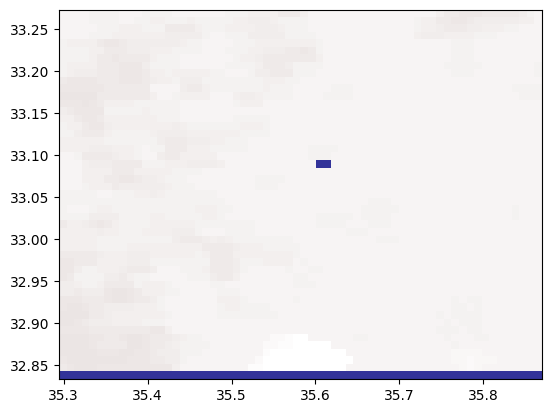

(49, 64)
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 64, 'height': 49, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008983152841195215, 0.0, 35.294807513056,
       0.0, -0.008983152841195215, 33.273598123787075)}
4326
/content/drive/MyDrive/remote_sensing_ran/clipped/Clipped_T0_2018_03_22.tif


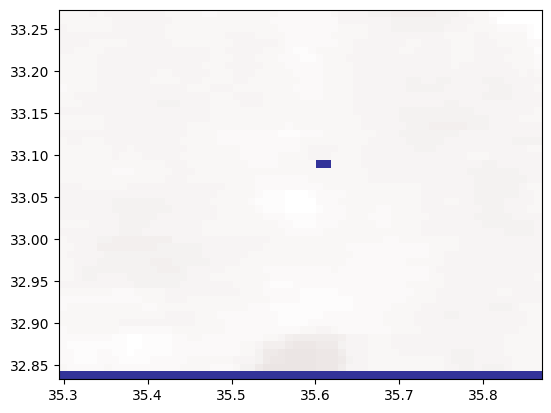

(49, 64)
{'driver': 'GTiff', 'dtype': 'int16', 'nodata': None, 'width': 127, 'height': 97, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.004491576420597608, 0.0, 35.294807513056,
       0.0, -0.004491576420597608, 33.273598123787075)}
4326
/content/drive/MyDrive/remote_sensing_ran/clipped/Clipped_alb_2018_03_22.tif


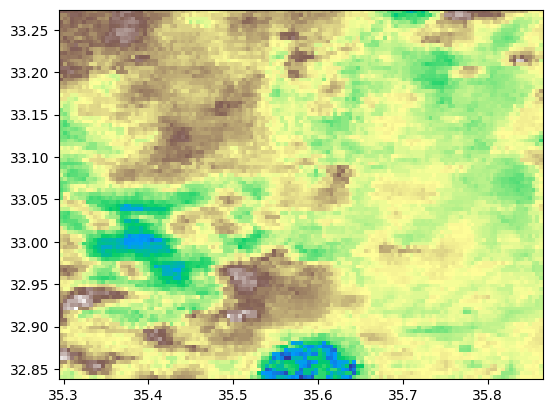

(97, 127)
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 127, 'height': 97, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.004491576420597608, 0.0, 35.294807513056,
       0.0, -0.004491576420597608, 33.273598123787075)}
4326
/content/drive/MyDrive/remote_sensing_ran/clipped/Clipped_Lai_2018_03_22.tif


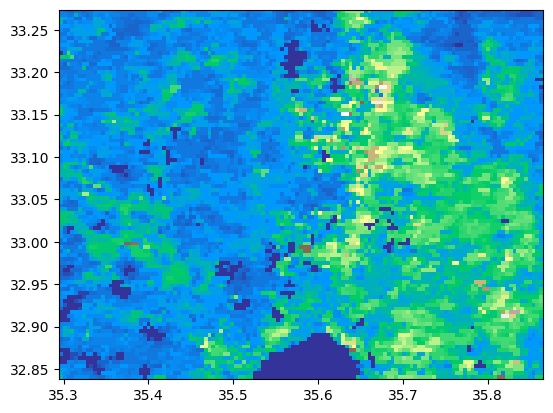

(97, 127)
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 64, 'height': 49, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008983152841195215, 0.0, 35.294807513056,
       0.0, -0.008983152841195215, 33.273598123787075)}
4326
/content/drive/MyDrive/remote_sensing_ran/clipped/Clipped_emis_2018_08_24.tif


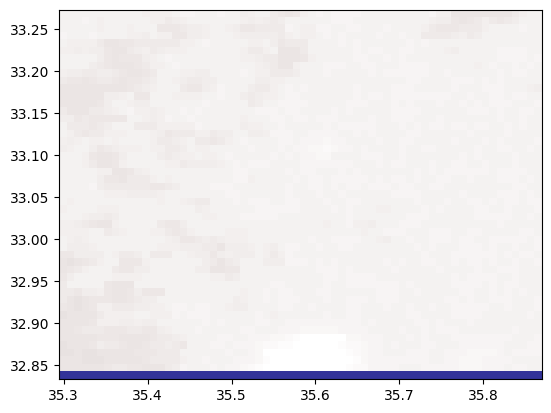

(49, 64)
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 64, 'height': 49, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008983152841195215, 0.0, 35.294807513056,
       0.0, -0.008983152841195215, 33.273598123787075)}
4326
/content/drive/MyDrive/remote_sensing_ran/clipped/Clipped_T0_2018_08_24.tif


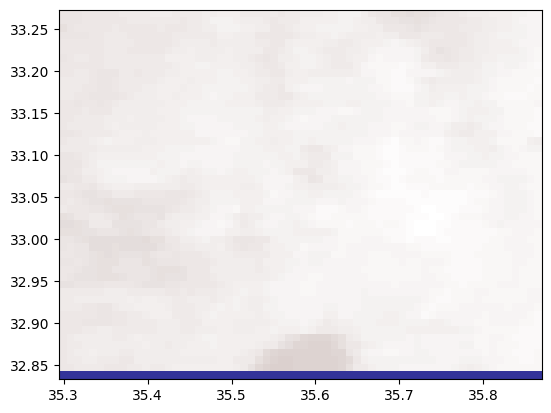

(49, 64)
{'driver': 'GTiff', 'dtype': 'int16', 'nodata': None, 'width': 127, 'height': 97, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.004491576420597608, 0.0, 35.294807513056,
       0.0, -0.004491576420597608, 33.273598123787075)}
4326
/content/drive/MyDrive/remote_sensing_ran/clipped/Clipped_alb_2018_08_24.tif


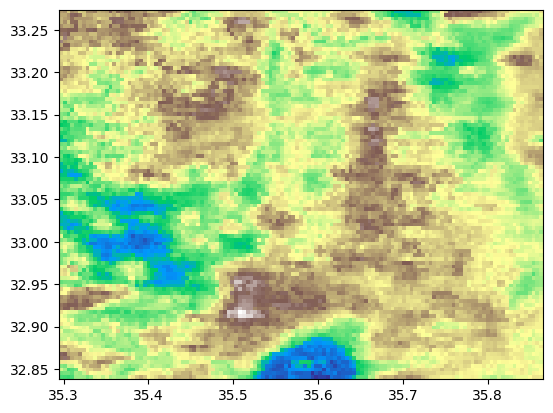

(97, 127)
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 127, 'height': 97, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.004491576420597608, 0.0, 35.294807513056,
       0.0, -0.004491576420597608, 33.273598123787075)}
4326
/content/drive/MyDrive/remote_sensing_ran/clipped/Clipped_Lai_2018_08_24.tif


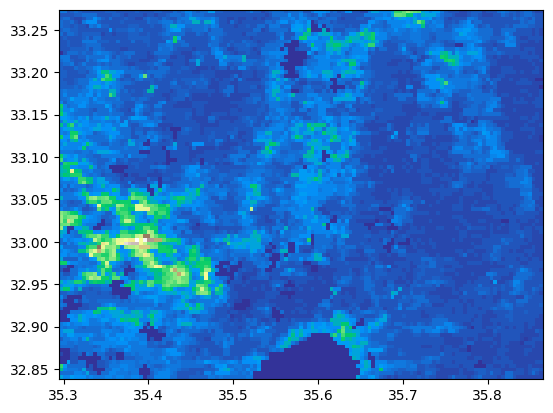

(97, 127)
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 127, 'height': 97, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.004491576420597608, 0.0, 35.294807513056,
       0.0, -0.004491576420597608, 33.273598123787075)}
4326
/content/drive/MyDrive/remote_sensing_ran/clipped/Clipped_LC_2018.tif


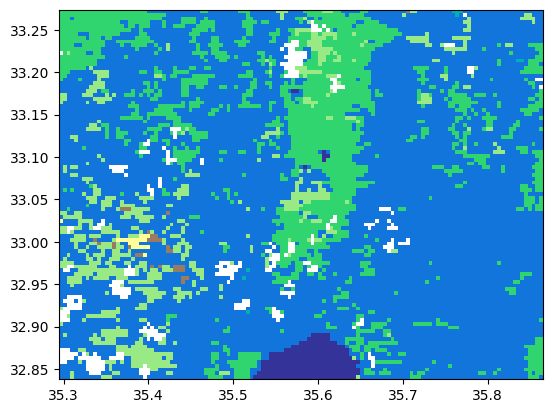

(97, 127)
{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -1.0, 'width': 3201, 'height': 3201, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.05, 0.0, -80.025,
       0.0, -0.05, 80.025)}
4326
/content/drive/MyDrive/remote_sensing_ran/clipped/Clipped_SW_2018_08_24.nc


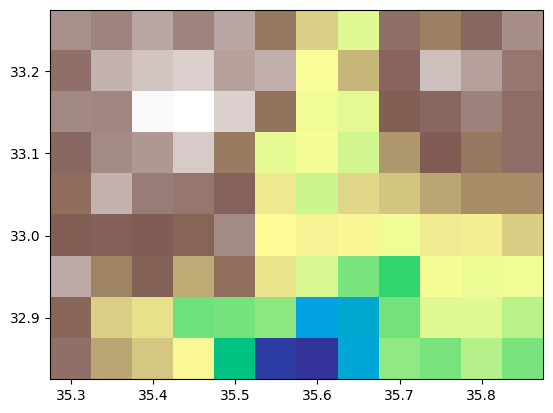

(9, 12)
{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -1.0, 'width': 3201, 'height': 3201, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.05, 0.0, -80.025,
       0.0, -0.05, 80.025)}
4326
/content/drive/MyDrive/remote_sensing_ran/clipped/Clipped_SW_2018_03_22.nc


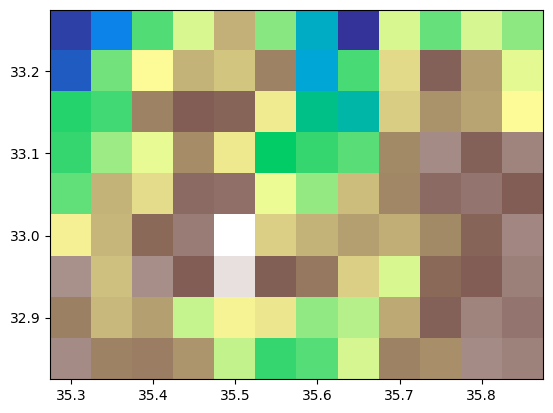

(9, 12)
{'driver': 'GTiff', 'dtype': 'int16', 'nodata': 0.0, 'width': 3201, 'height': 3201, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.05, 0.0, -80.025,
       0.0, -0.05, 80.025)}
4326
/content/drive/MyDrive/remote_sensing_ran/clipped/Clipped_LW_2018_08_24.nc


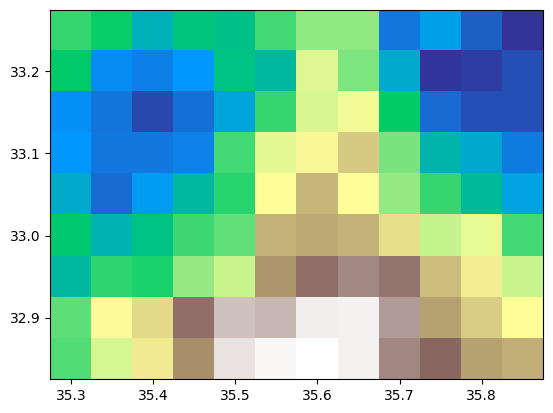

(9, 12)
{'driver': 'GTiff', 'dtype': 'int16', 'nodata': 0.0, 'width': 3201, 'height': 3201, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.05, 0.0, -80.025,
       0.0, -0.05, 80.025)}
4326
/content/drive/MyDrive/remote_sensing_ran/clipped/Clipped_LW_2018_03_22.nc


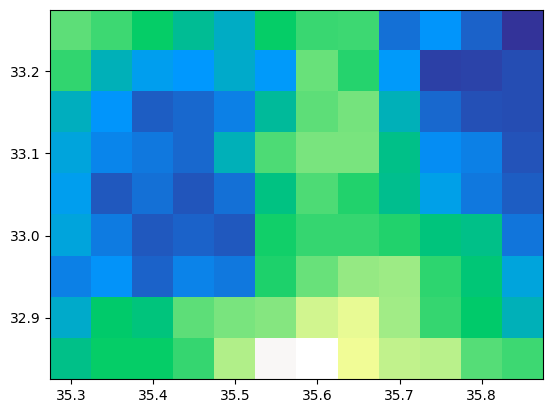

(9, 12)
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 113, 'height': 248, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.02097294833457309, 0.0, 34.030197655291886,
       0.0, -0.017903525148707074, 33.63604130188446)}
4326
/content/drive/MyDrive/remote_sensing_ran/clipped/Clipped_wrfout_d02_2018-03-22_13_00_00_T2_wg84.tif


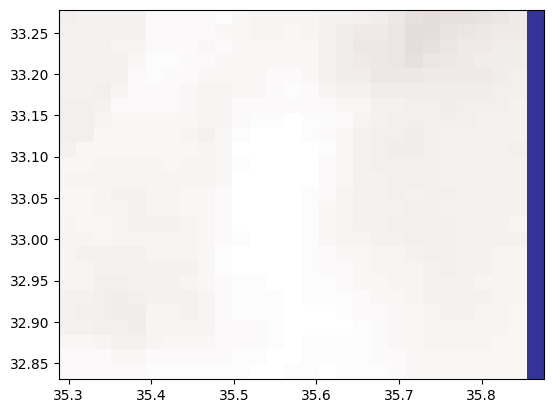

(25, 28)
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 113, 'height': 248, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.02097294833457309, 0.0, 34.030197655291886,
       0.0, -0.017903525148707074, 33.63604130188446)}
4326
/content/drive/MyDrive/remote_sensing_ran/clipped/Clipped_wrfout_d02_2018-08-24_13_00_00_T2_wg84.tif


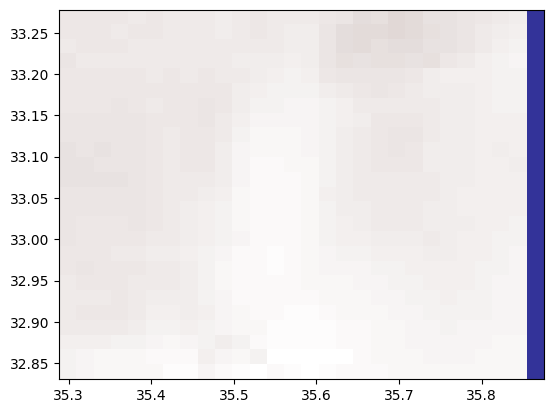

(25, 28)
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 113, 'height': 248, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.02097294833457309, 0.0, 34.030197655291886,
       0.0, -0.017903525148707074, 33.63604130188446)}
4326
/content/drive/MyDrive/remote_sensing_ran/clipped/Clipped_wrfout_d02_2018-08-24_13_00_00_U10_wg84.tif


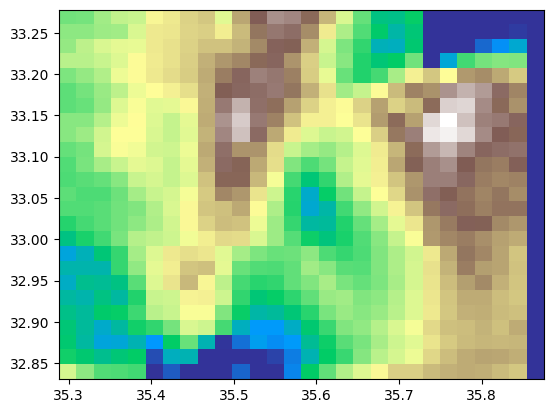

(25, 28)
{'driver': 'GTiff', 'dtype': 'float64', 'nodata': 0.0, 'width': 113, 'height': 248, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.020972948336283173, 0.0, 34.030197655,
       0.0, -0.017903525149193553, 33.636041302)}
4326
/content/drive/MyDrive/remote_sensing_ran/clipped/Clipped_wrfout_d02_2018-08-24_13_00_00_V10_wg84.tif


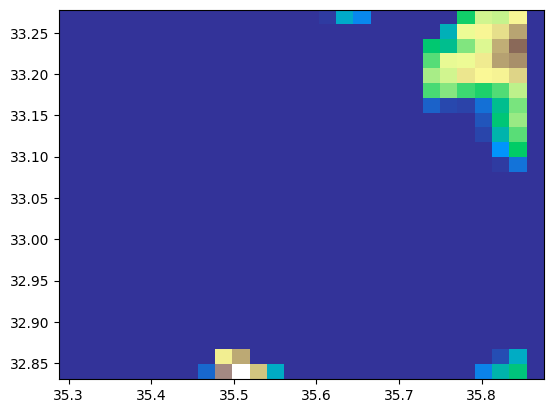

(25, 28)
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 113, 'height': 248, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.02097294833457309, 0.0, 34.030197655291886,
       0.0, -0.017903525148707074, 33.63604130188446)}
4326
/content/drive/MyDrive/remote_sensing_ran/clipped/Clipped_wrfout_d02_2018-03-22_13_00_00_U10_wg84.tif


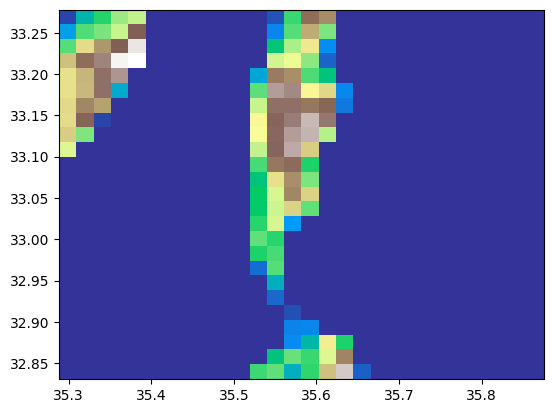

(25, 28)
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 113, 'height': 248, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.02097294833457309, 0.0, 34.030197655291886,
       0.0, -0.017903525148707074, 33.63604130188446)}
4326
/content/drive/MyDrive/remote_sensing_ran/clipped/Clipped_wrfout_d02_2018-03-22_13_00_00_V10_wg84.tif


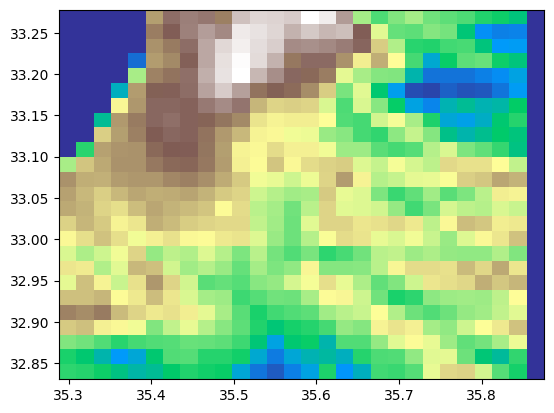

(25, 28)


In [20]:
implement_geodataframe(coords, emis_03)
implement_geodataframe(coords, t0_03)
implement_geodataframe(coords, alb_03)
implement_geodataframe(coords, Lai_03)
implement_geodataframe(coords, emis_08)
implement_geodataframe(coords, t0_08)
implement_geodataframe(coords, alb_08)
implement_geodataframe(coords, Lai_08)
implement_geodataframe(coords, LC)

implement_geodataframe(coords, sw08)
implement_geodataframe(coords, sw03)
implement_geodataframe(coords, lw08)
implement_geodataframe(coords, lw03)

implement_geodataframe(coords, t208)
implement_geodataframe(coords, t203)
implement_geodataframe(coords, u1008)
implement_geodataframe(coords, v1008)
implement_geodataframe(coords, u1003)
implement_geodataframe(coords, v1003)

### Resampling

In [21]:
ref = 'clipped/Clipped_alb_2018_08_24.tif'

resample('clipped/Clipped_alb_2018_08_24.tif', ref, 'resampled/ALB_08_resampled')
resample('clipped/Clipped_emis_2018_08_24.tif', ref, 'resampled/EMIS_08_resampled')
resample('clipped/Clipped_Lai_2018_08_24.tif', ref, 'resampled/LAI_08_resampled')
resample('clipped/Clipped_T0_2018_08_24.tif', ref, 'resampled/T0_08_resampled')
resample('clipped/Clipped_SW_2018_08_24.nc', ref, 'resampled/SW_08_resampled')
resample('clipped/Clipped_LW_2018_08_24.nc', ref, 'resampled/LW_08_resampled')

resample('clipped/Clipped_alb_2018_03_22.tif', ref, 'resampled/ALB_03_resampled')
resample('clipped/Clipped_emis_2018_03_22.tif', ref, 'resampled/EMIS_03_resampled')
resample('clipped/Clipped_Lai_2018_03_22.tif', ref, 'resampled/LAI_03_resampled')
resample('clipped/Clipped_T0_2018_03_22.tif', ref, 'resampled/T0_03_resampled')
resample('clipped/Clipped_SW_2018_03_22.nc', ref, 'resampled/SW_03_resampled')
resample('clipped/Clipped_LW_2018_03_22.nc', ref, 'resampled/LW_03_resampled')

resample('clipped/Clipped_LC_2018.tif', ref, 'resampled/LC_resampled')

#wrfs
resample('clipped/Clipped_wrfout_d02_2018-03-22_13_00_00_T2_wg84.tif', ref, 'resampled/T2_03_resampled')
resample('clipped/Clipped_wrfout_d02_2018-08-24_13_00_00_T2_wg84.tif', ref, 'resampled/T2_08_resampled')
resample('clipped/Clipped_wrfout_d02_2018-03-22_13_00_00_U10_wg84.tif', ref, 'resampled/U10_03_resampled')
resample('clipped/Clipped_wrfout_d02_2018-08-24_13_00_00_U10_wg84.tif', ref, 'resampled/U10_08_resampled')
resample('clipped/Clipped_wrfout_d02_2018-03-22_13_00_00_V10_wg84.tif', ref, 'resampled/V10_03_resampled')
resample('clipped/Clipped_wrfout_d02_2018-08-24_13_00_00_V10_wg84.tif', ref, 'resampled/V10_08_resampled')


/content/drive/MyDrive/remote_sensing_ran/clipped/Clipped_alb_2018_08_24.tif
/content/drive/MyDrive/remote_sensing_ran/clipped/Clipped_emis_2018_08_24.tif
/content/drive/MyDrive/remote_sensing_ran/clipped/Clipped_Lai_2018_08_24.tif
/content/drive/MyDrive/remote_sensing_ran/clipped/Clipped_T0_2018_08_24.tif
/content/drive/MyDrive/remote_sensing_ran/clipped/Clipped_SW_2018_08_24.nc
/content/drive/MyDrive/remote_sensing_ran/clipped/Clipped_LW_2018_08_24.nc
/content/drive/MyDrive/remote_sensing_ran/clipped/Clipped_alb_2018_03_22.tif
/content/drive/MyDrive/remote_sensing_ran/clipped/Clipped_emis_2018_03_22.tif
/content/drive/MyDrive/remote_sensing_ran/clipped/Clipped_Lai_2018_03_22.tif
/content/drive/MyDrive/remote_sensing_ran/clipped/Clipped_T0_2018_03_22.tif
/content/drive/MyDrive/remote_sensing_ran/clipped/Clipped_SW_2018_03_22.nc
/content/drive/MyDrive/remote_sensing_ran/clipped/Clipped_LW_2018_03_22.nc
/content/drive/MyDrive/remote_sensing_ran/clipped/Clipped_LC_2018.tif
/content/drive

<open DatasetReader name='/content/drive/MyDrive/remote_sensing_ran/resampled/V10_08_resampled.tif' mode='r'>

## Rn Calculation

In [22]:
# Rn for 08
alb_08_array = raster_to_array('resampled/ALB_08_resampled.tif', 0.001)
sw_08_array = raster_to_array('resampled/SW_08_resampled.tif', 0.1)
lw_08_array = raster_to_array('resampled/LW_08_resampled.tif', 0.1)
t0_08_array = raster_to_array('resampled/T0_08_resampled.tif', 0.02)
emis_08_array = raster_to_array('resampled/EMIS_08_resampled.tif', 0.002)

# Rn for 03
alb_03_array = raster_to_array('resampled/ALB_03_resampled.tif', 0.001)
sw_03_array = raster_to_array('resampled/SW_03_resampled.tif', 0.1)
lw_03_array = raster_to_array('resampled/LW_03_resampled.tif', 0.1)
t0_03_array = raster_to_array('resampled/T0_03_resampled.tif', 0.02)
emis_03_array = raster_to_array('resampled/EMIS_03_resampled.tif', 0.002)

In [23]:
def calculate_Rn(sw_array, lw_array, alb_array, emis_array, t0_array):
    σ = 5.6697 * 10**(-8) # Stefan Bolzman constant [W*m^-2*K^-4]
    σ_array = (alb_array / alb_array) * σ
    Rn_array = (sw_array * (1 - alb_array)) + (lw_array) - (lw_array * (1 - emis_array)) - (emis_array * σ_array * (t0_array ** 4))
    return Rn_array.where(Rn_array > 0)

Rn stats for the date 2018-03-22
mean: 401.943983900154
median: 401.11747517015067
minimun value: 363.35105114483576
maximum value: 540.0894532169189

Rn stats for the date 2018-08-24
mean: 444.21510581179496
median: 441.4106483839645
minimun value: 399.5573589893164
maximum value: 539.6366668979549


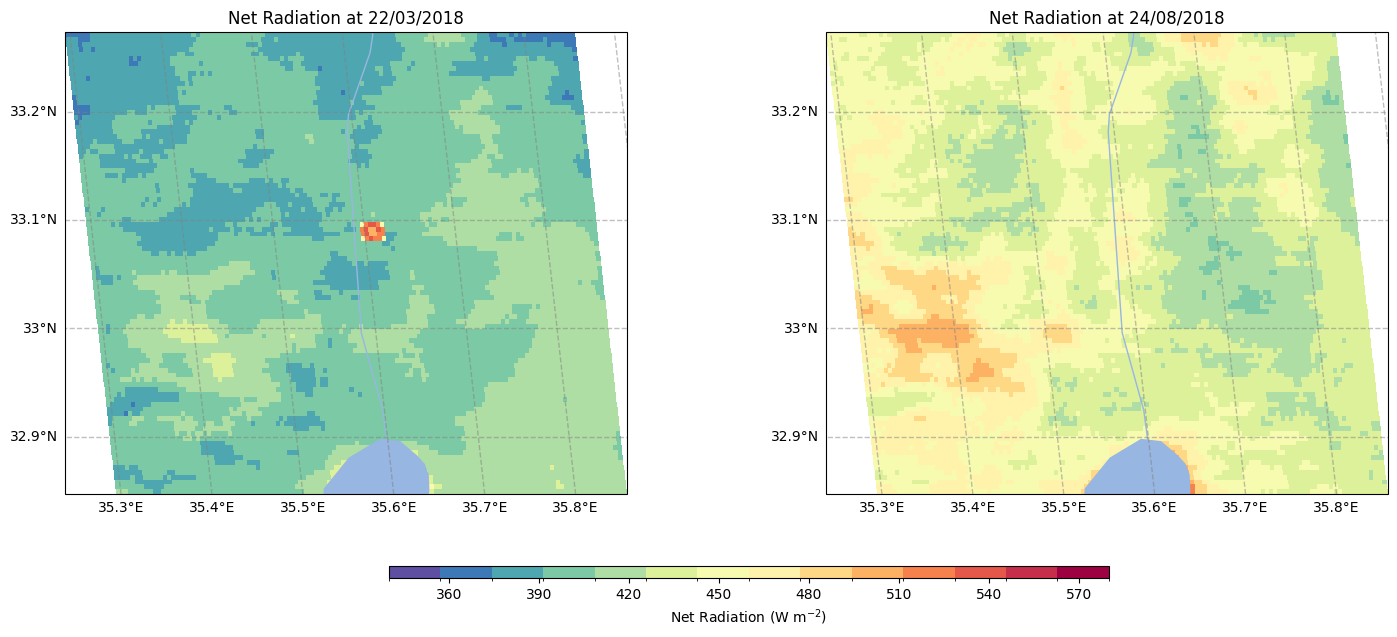

In [24]:
# calculate Rn for 08 and 03
Rn_08 = calculate_Rn(sw_08_array, lw_08_array, alb_08_array, emis_08_array, t0_08_array)
Rn_03 = calculate_Rn(sw_03_array, lw_03_array, alb_03_array, emis_03_array, t0_03_array)
Rn_08 = crop_raster(Rn_08)
Rn_03 = crop_raster(Rn_03)

calc_stats(Rn_03, Rn_08, 'Rn')
present_rasters('Net Radiation', Rn_08, Rn_03, 340, 580, '(W m$^{-2}$)')


sloppe 0.556387046223843
intercept 220.57867986214433

The linear regression equation is: y=0.56x + 220.58
The R-squared value is: 0.13


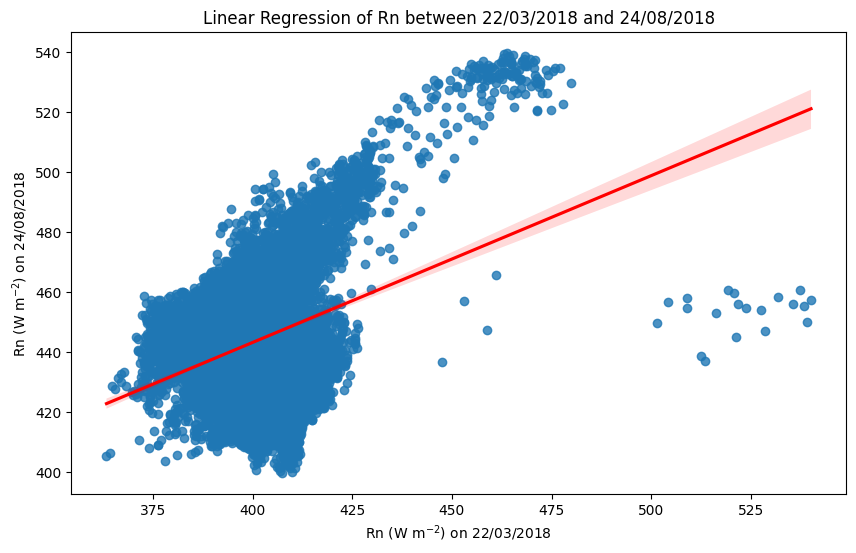

In [25]:
scatter_plot(Rn_03, Rn_08, 'Rn', units='(W m$^{-2}$)')


## G Calculation

In [26]:
def G_calculation(Rn_array, LAI, b):
  # zenith angle from http://www.solartopo.com/solar-orbit.htm

  b = b * np.pi/180
  tetha = 90 - b
  kdr = 0.5/math.sin(b)
  tetha_array = (Rn_array / Rn_array) * tetha
  kdr_array = (Rn_array / Rn_array) * kdr
  tau = np.exp(-kdr_array * LAI)
  G = 0.35 * (tau * Rn_array) * np.cos(tetha_array)
  return G

G flux stats for the date 2018-03-22
mean: 36.39929704080512
median: 37.12424956853404
minimun value: 1.358954011955929
maximum value: 96.8326851618729

G flux stats for the date 2018-08-24
mean: 78.25283756906042
median: 80.76943510682274
minimun value: 5.291841783048238
maximum value: 123.68721019020666


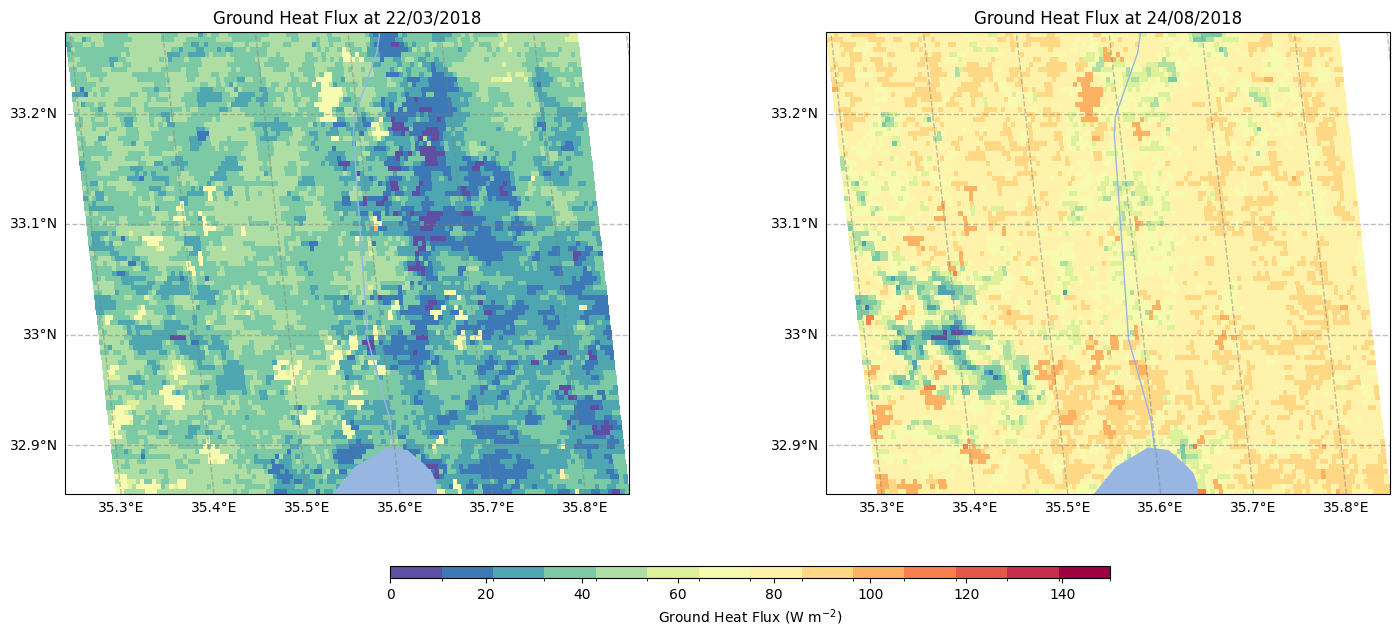

In [27]:

Lai_03 = raster_to_array('resampled/LAI_03_resampled.tif', 0.1)
Lai_08 = raster_to_array('resampled/LAI_08_resampled.tif', 0.1)

G_08 = G_calculation(Rn_08, Lai_08, 67.55)
G_03 = G_calculation(Rn_03, Lai_03, 57.54)

G_08 = crop_raster(G_08)
G_03 = crop_raster(G_03)

calc_stats(G_03, G_08, 'G flux')
present_rasters('Ground Heat Flux', G_08, G_03, 0, 150, '(W m$^{-2}$)')

sloppe 0.2656176521740809
intercept 68.58454174829481

The linear regression equation is: y=0.27x + 68.58
The R-squared value is: 0.07


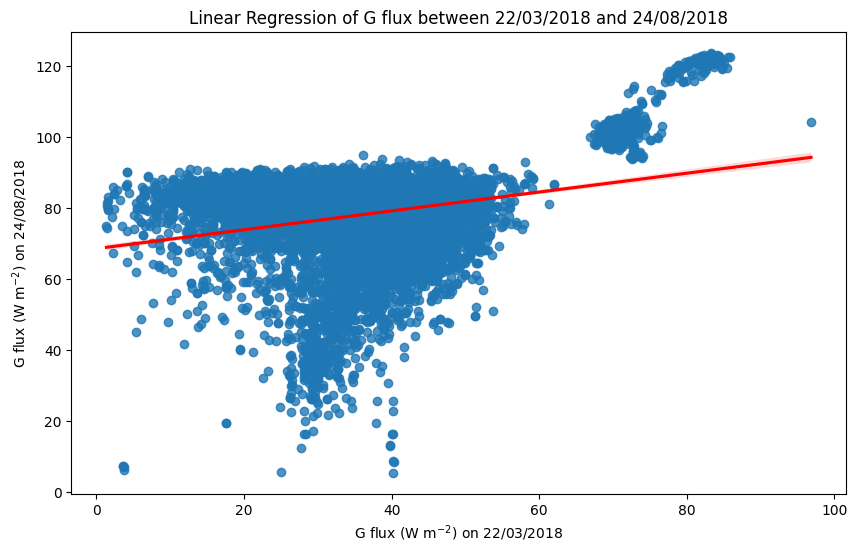

In [28]:
scatter_plot(G_03, G_08, 'G flux', units='(W m$^{-2}$)')

## H Calculation

### Calculating Delta T

Temperature stats for the date 2018-03-22
mean: 300.3727102139205
median: 300.40959620588654
minimun value: 289.1198647971295
maximum value: 305.5917084878085

Temperature stats for the date 2018-08-24
mean: 303.4406044110429
median: 303.153374340836
minimun value: 293.11744677625455
maximum value: 311.88070824741027


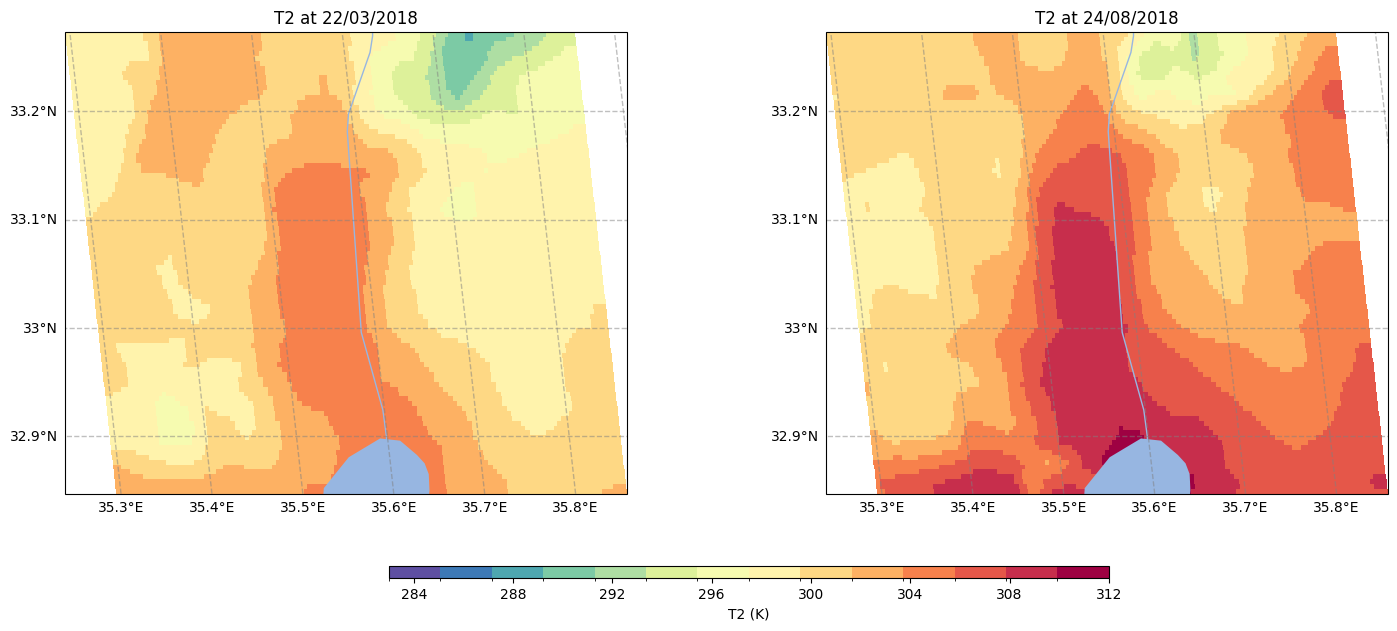

In [29]:
ta_array03 = raster_to_array('resampled/T2_03_resampled.tif', 1)
ta_array08 = raster_to_array('resampled/T2_08_resampled.tif', 1)

ta_array03 = crop_raster(ta_array03)
ta_array08 = crop_raster(ta_array08)

calc_stats(ta_array03, ta_array08, 'Temperature')
present_rasters('T2', ta_array08, ta_array03, 283, 312, '(K)')

Delta T stats for the date 2018-03-22
mean: 0.9596249439743508
median: 0.9872437087933008
minimun value: -228.08986045142996
maximum value: 12.09881314147691

Delta T stats for the date 2018-08-24
mean: 14.860658746851882
median: 14.966472231479088
minimun value: -8.10320824741018
maximum value: 25.210662192217455


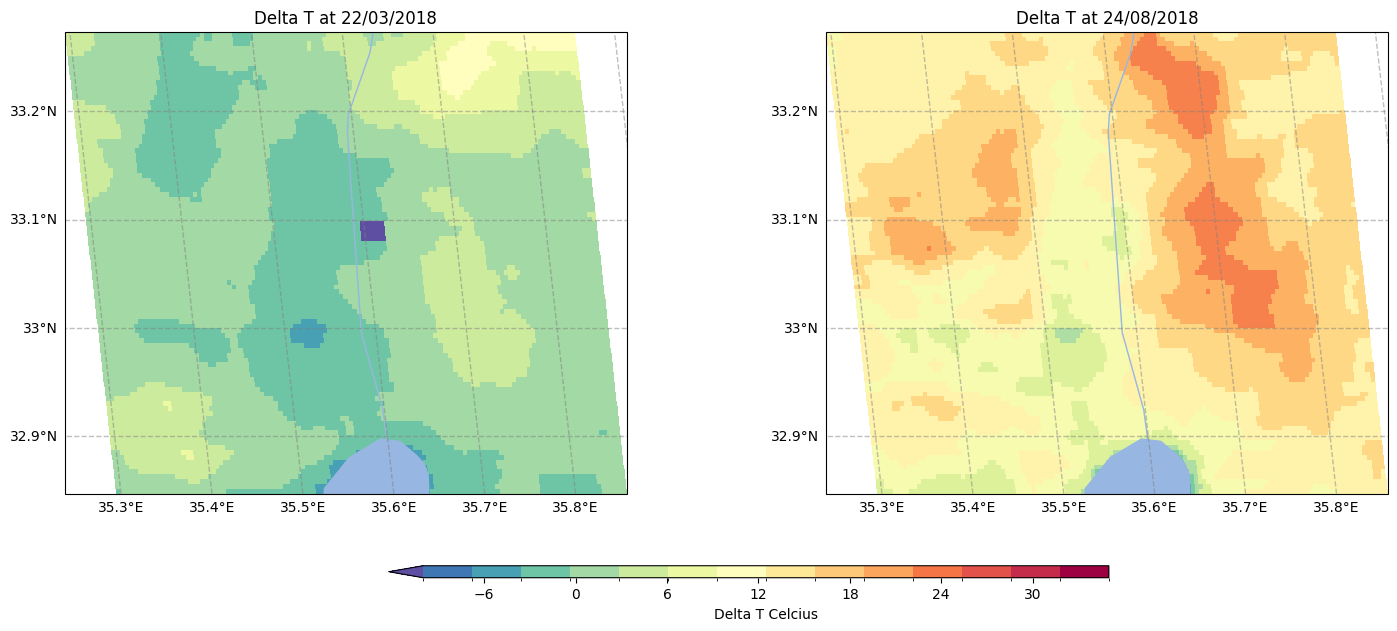

In [30]:
def deltaT(ta_raster,scale_ta, t0_raster, scale_t0):
  t0_array = raster_to_array(t0_raster, scale_t0)
  ta_array = raster_to_array(ta_raster, scale_ta)
  deltaT_array = (t0_array - ta_array)
  return deltaT_array

deltaT_08 = deltaT('resampled/T2_08_resampled.tif', 1, 'resampled/T0_08_resampled.tif', 0.02)
deltaT_03 = deltaT('resampled/T2_03_resampled.tif', 1, 'resampled/T0_03_resampled.tif', 0.02)

deltaT_08 = crop_raster(deltaT_08)
deltaT_03 = crop_raster(deltaT_03)

calc_stats(deltaT_03, deltaT_08, 'Delta T')
present_rasters('Delta T', deltaT_08, deltaT_03, -10, 35, 'Celcius')


### Calculating the Wind Speed

Wind Speed stats for the date 2018-03-22
mean: 3.229544255444184
median: 3.1456354932686397
minimun value: 0.07993150502443314
maximum value: 6.958202431523492

Wind Speed stats for the date 2018-08-24
mean: 4.960226501323773
median: 4.842900910615325
minimun value: 0.0
maximum value: 10.206595747613473


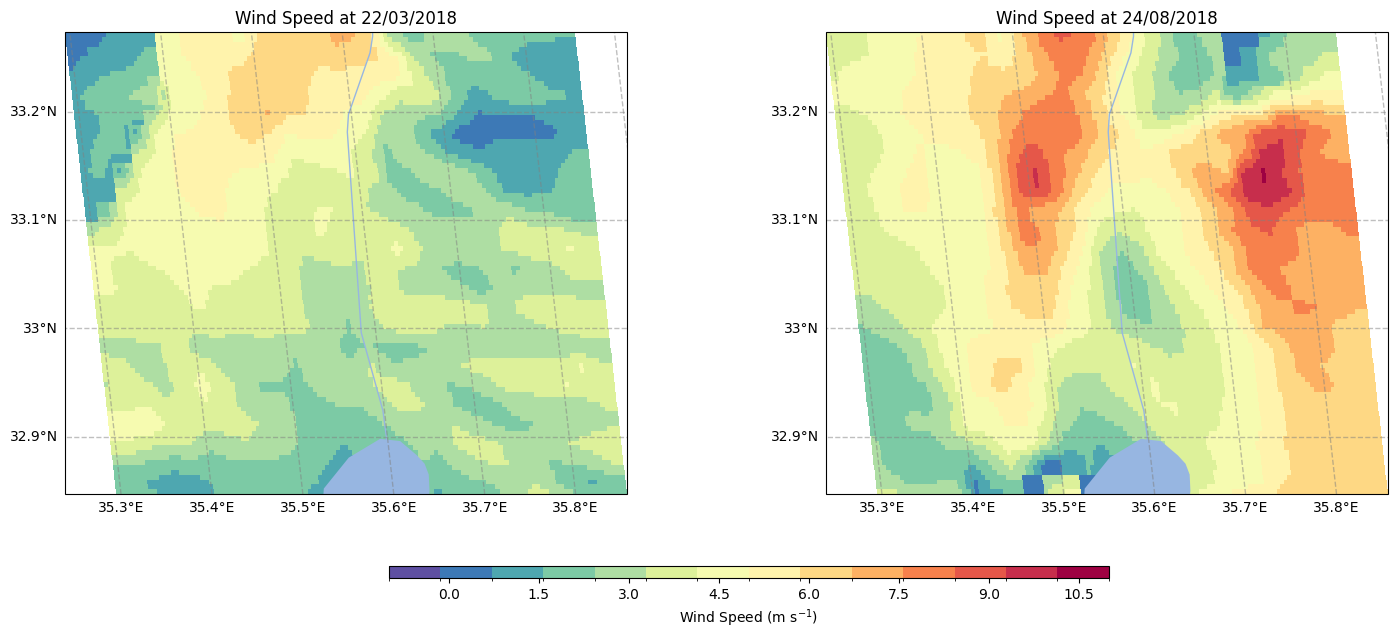

In [31]:
def wind_calc(u10_raster, v10_raster):
  u10_array = raster_to_array(u10_raster, 1)
  v10_array = raster_to_array(v10_raster, 1)
  wind_array = np.sqrt(u10_array**2 + v10_array**2)
  return wind_array


wind_08 = wind_calc('resampled/U10_08_resampled.tif', 'resampled/V10_08_resampled.tif')
wind_03 = wind_calc('resampled/U10_03_resampled.tif', 'resampled/V10_03_resampled.tif')

wind_08 = crop_raster(wind_08)
wind_03 = crop_raster(wind_03)

calc_stats(wind_03, wind_08, 'Wind Speed')
present_rasters('Wind Speed', wind_08, wind_03, -1, 11, '(m s$^{-1}$)')

### Land Cover Analysis

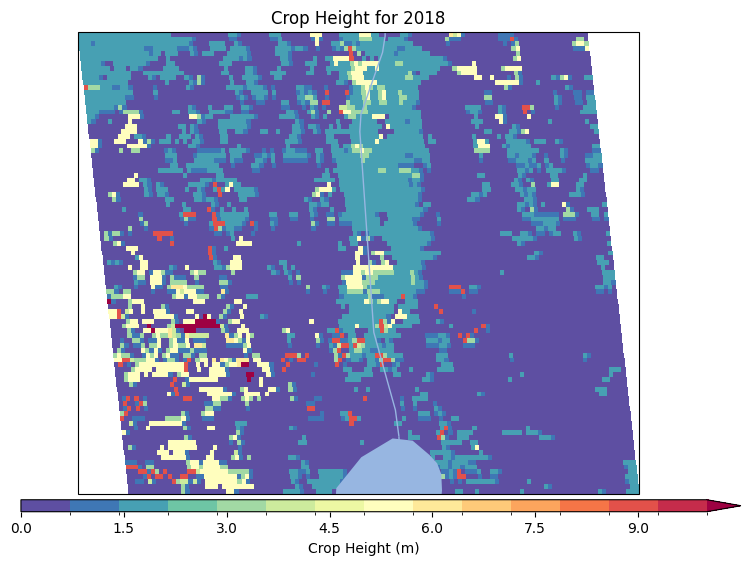

In [32]:
lc = LC.raster_
# for the Land Cover we will use the clipped and not the resampled, because the resolution is 500m.
lc_array = raster_to_array('resampled/LC_resampled.tif', 1)

height_array = lc_array.copy()

height_dict = {
    0 : 0.01, # Water Bodies: at least 60% of area is covered by permanent water bodies.
    1 : 0.3, # Grasslands: dominated by herbaceous annuals (<2m) including cereal croplands.
    2 : 1, # Shrublands: shrub (1-2m) cover >10%.
    3 : 2, # Broadleaf Croplands: bominated by herbaceous annuals (<2m) that are cultivated with broadleaf crops.
    4 : 5, # 	Savannas: between 10-60% tree cover (>2m).
    5 : 15, # Evergreen Broadleaf Forests: dominated by evergreen broadleaf and palmate trees (canopy >2m). Tree cover >60%.
    6 : 15, # Deciduous Broadleaf Forests: dominated by deciduous broadleaf trees (canopy >2m). Tree cover >60%.
    7 : 15, # Evergreen Needleleaf Forests: dominated by evergreen conifer trees (canopy >2m). Tree cover >60%.
    8 : 15, # Deciduous Needleleaf Forests: dominated by deciduous needleleaf (larch) trees (canopy >2m). Tree cover >60%.
    9 : 0.1, # Non-Vegetated Lands: at least 60% of area is non-vegetated barren (sand, rock, soil) or permanent snow and ice with less than 10% vegetation.
    10 : 0.01, # Urban and Built-up Lands: at least 30% impervious surface area including building materials, asphalt and vehicles.
    255 : 0.01
}

# replace values based on the dictionary
def replace_values(value):
    return height_dict.get(value, value)

# extract the dataarray
band_data = height_array['band_data']

# Replace the values using the function we created
new_data_band = xr.apply_ufunc(
    replace_values,
    band_data,
    vectorize=True
)

# update the dataset with the new dataarray
height_array['band_data'] = new_data_band

# replacing 0 values with 0.001 so we won't get empty values (white pixels)
height_array['band_data'] = height_array['band_data'].where(height_array['band_data'] != 0, 0.001)

height_array = crop_raster(height_array)


# plotting height_array

fig, ax = plt.subplots(figsize=(18, 6), subplot_kw={'projection': ccrs.Robinson()})

ax.coastlines()
ax.add_feature(cartopy.feature.OCEAN, alpha=1.0)
ax.add_feature(cartopy.feature.LAKES, alpha=1.0)
ax.add_feature(cartopy.feature.RIVERS)
p1 = height_array['band_data'].plot(ax=ax, levels=15, vmin=0, vmax=10, cmap='Spectral_r', transform=ccrs.PlateCarree(), add_colorbar=False)
ax.set_title(f'Crop Height for 2018')

# adjust color bar axis
cax = fig.add_axes([0.325, 0.08, 0.4, 0.02])
tick_locator = ticker.MaxNLocator(nbins=8)
cb = fig.colorbar(p1, cax=cax, orientation='horizontal')
cb.locator = tick_locator
cb.update_ticks()
cb.ax.set_xlabel(f'Crop Height (m)')

plt.show()


### Calculating rah

In [33]:
def calc_rah(wind_array, height_array):

  h = height_array
  d = 0.64 * h # (Allen et al., 1998)
  z0 = 0.13 * h # (Stanhill, 1969; Szeicz et al., 1969; Monteith, 1998)
  k = 0.397 # Karman's constant (Frenzen & Vogel 1995)
  zr = 10
  n = 2.5 # (monteith, 1975)

  ustar = (k * wind_array) / np.log( ( zr - d ) / z0 )

  Kh = k * ustar * h

  # -----

  zs = 0.1
  r_ah_s = ( ( h * np.exp(n) ) / (n * Kh) ) * np.exp(-n * (zs/h)) - np.exp( -n * ((z0+d) / h) )

  r_ah_a = (1/(k*ustar)) * np.log((zr-d)/(h-d)) + (h/(n*Kh)) * np.exp(n*(1-(z0+d)/n)-1)

  rah = r_ah_s + r_ah_a
  # -----

  return rah




rah stats for the date 2018-03-22
mean: 239.08045802369915
median: 225.45349696278706
minimun value: -7.906456696934198
maximum value: 3208.749301752713

rah stats for the date 2018-08-24
mean: inf
median: 132.56926830955942
minimun value: -7.2709954884114065
maximum value: inf


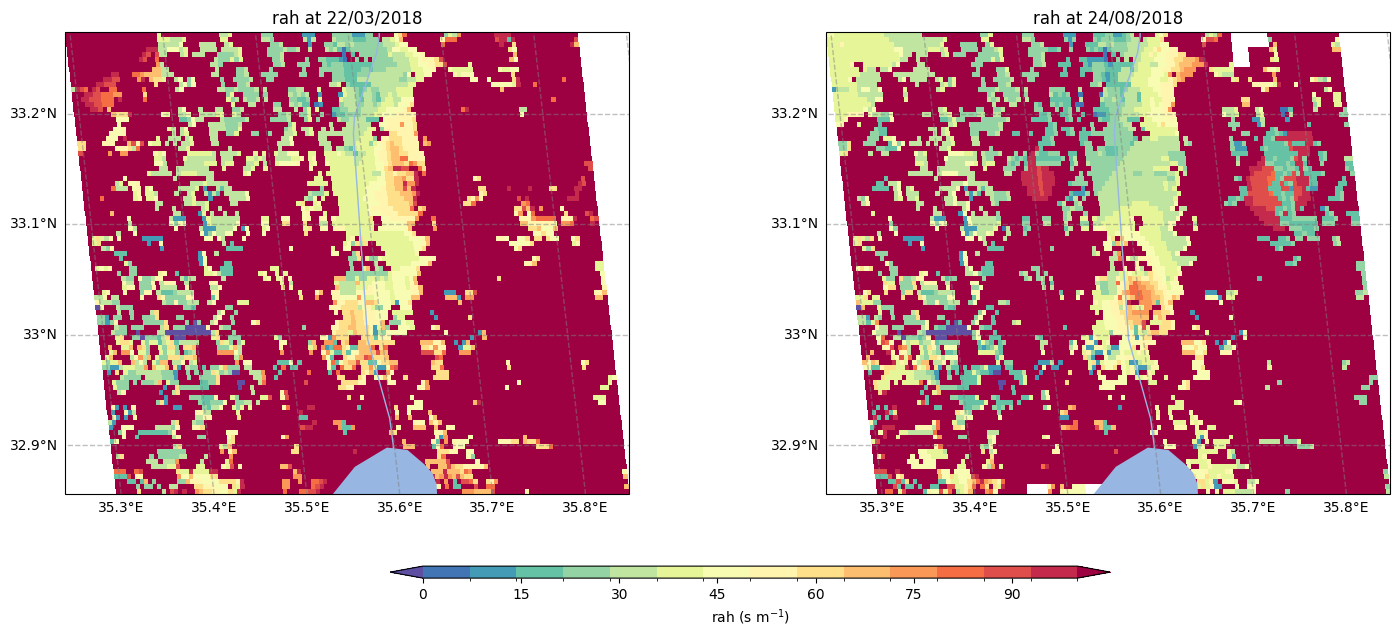

In [34]:
rah_08 = calc_rah(wind_08, height_array)
rah_03 = calc_rah(wind_03, height_array)

rah_08 = crop_raster(rah_08)
rah_03 = crop_raster(rah_03)

calc_stats(rah_03, rah_08, 'rah')

present_rasters('rah', rah_08, rah_03, 0, 100, '(s m$^{-1}$)')

sloppe nan
intercept nan

The linear regression equation is: y=nanx + nan
The R-squared value is: nan


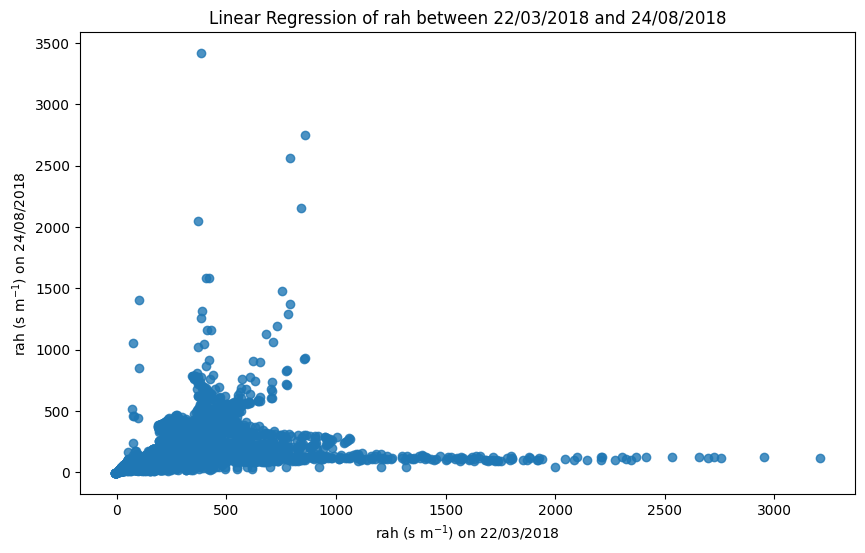

In [35]:
scatter_plot(rah_03, rah_08, 'rah', units='(s m$^{-1}$)')

### Calculate H

Sensible Heat flux stats for the date 2018-03-22
mean: 7.581381301085367
median: 5.191350479459073
minimun value: -6510.933834324946
maximum value: 619.2722703359785

Sensible Heat flux stats for the date 2018-08-24
mean: 261.60046116311247
median: 147.56169378679672
minimun value: -3144.2768996794225
maximum value: 3658.1588657884477


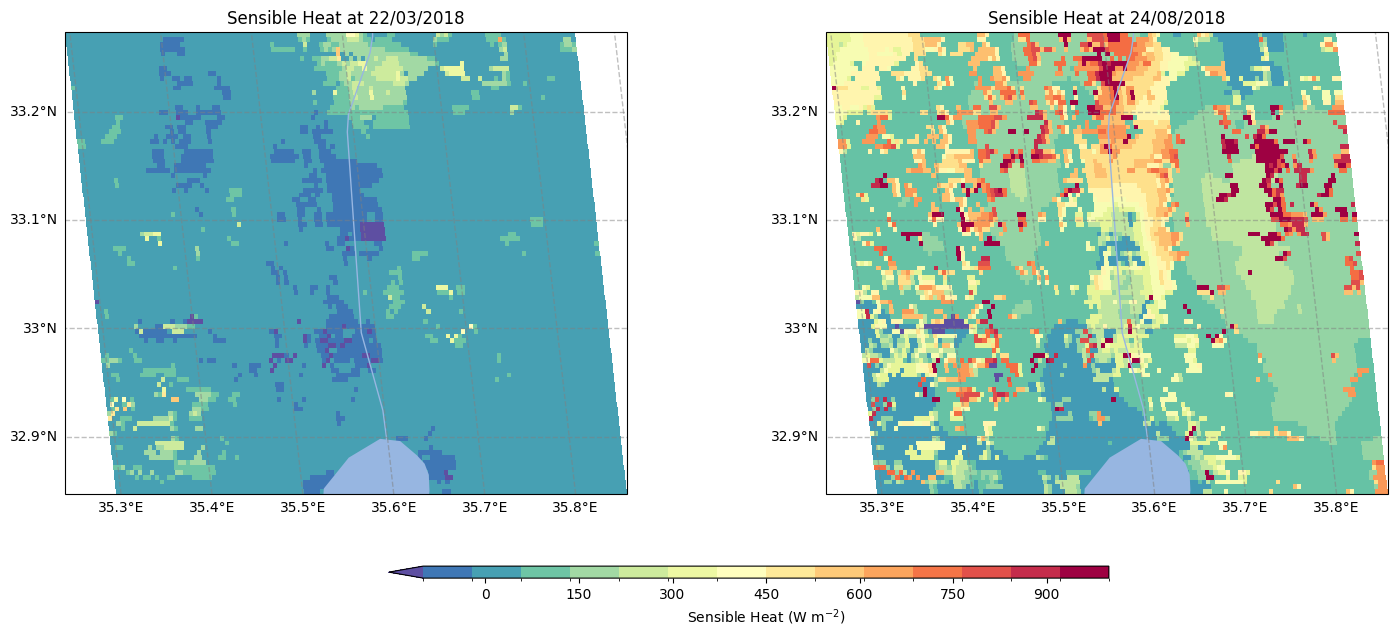

In [36]:
def calc_sensible_heat(DeltaT, rah, ref_array):
  Cp = 1000 # J/(Kg*K)
  ro = 1.199 # Kg/m^3
  H = ro * Cp * (DeltaT/rah)
  # print(f'cp: {Cp}, ro: {ro}, DeltaT: {DeltaT}, rah: {rah}')

  # replacing 0 values with 0.001
  H['band_data'] = H['band_data'].where(H['band_data'] != 0, 0.001)
  return H

rah_08 = calc_rah(wind_08, height_array)
rah_03 = calc_rah(wind_03, height_array)

H_08 = calc_sensible_heat(deltaT_08, rah_08, wind_08)
H_03 = calc_sensible_heat(deltaT_03, rah_03, wind_03)

# H_08 = crop_raster(H_08)
# H_03 = crop_raster(H_03)

calc_stats(H_03, H_08, 'Sensible Heat flux')
present_rasters('Sensible Heat', H_08, H_03, -100, 1000, '(W m$^{-2}$)')

sloppe 0.19151111609043886
intercept -260.1485423686344

The linear regression equation is: y=0.19x + -260.15
The R-squared value is: 0.01


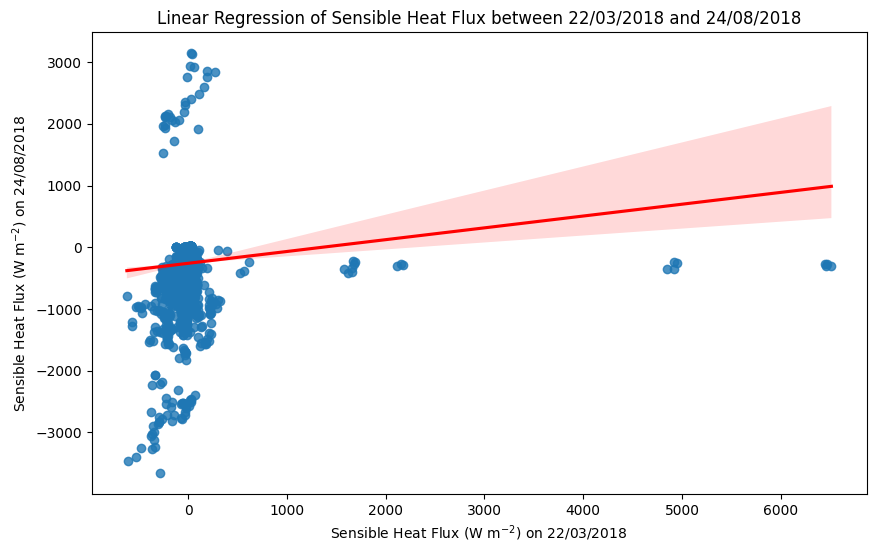

In [37]:
scatter_plot(-H_03, -H_08, 'Sensible Heat Flux', units='(W m$^{-2}$)')

## LE Calculation

Latent Heat Flux stats for the date 2018-03-22
mean: 357.11262295954185
median: 360.41811992287387
minimun value: -298.122703951926
maximum value: 6975.36392440593

Latent Heat Flux stats for the date 2018-08-24
mean: 98.94956246401135
median: 199.06844398921993
minimun value: -3328.6766315415234
maximum value: 3598.484129783393


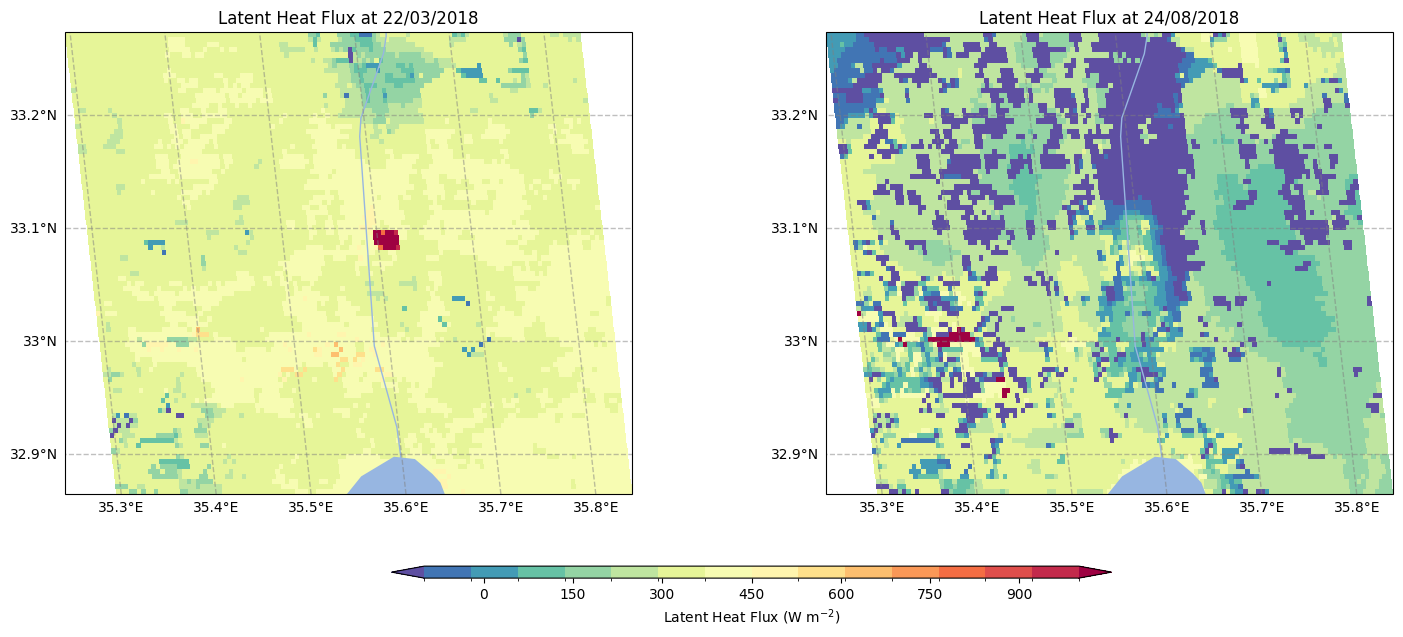

In [38]:
# Rn = -G - H + LE
# LE = Rn - G - H

LE_08 = Rn_08 - G_08 - H_08
LE_03 = Rn_03 - G_03 - H_03

LE_08 = crop_raster(LE_08)
LE_03 = crop_raster(LE_03)

calc_stats(LE_03, LE_08, 'Latent Heat Flux')
present_rasters('Latent Heat Flux', LE_08, LE_03, -100, 1000, '(W m$^{-2}$)')

sloppe 0.21271140212577092
intercept 22.98763571747544

The linear regression equation is: y=0.21x + 22.99
The R-squared value is: 0.01


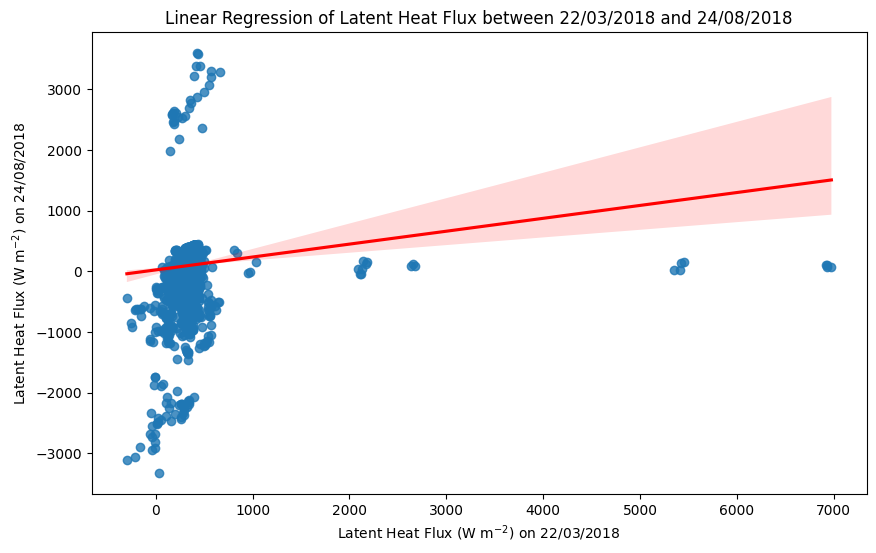

In [39]:
scatter_plot(LE_03, LE_08, 'Latent Heat Flux', units='(W m$^{-2}$)')

## ET Calcuation

Evapotranspiration stats for the date 2018-03-22
mean: 12.587408553168265
median: 12.700113031647213
minimun value: -10.516401687931156
maximum value: 246.05884750188517

Evapotranspiration stats for the date 2018-08-24
mean: 3.3692686606439413
median: 6.974211787402279
minimun value: -118.32494819752019
maximum value: 127.91583424222053


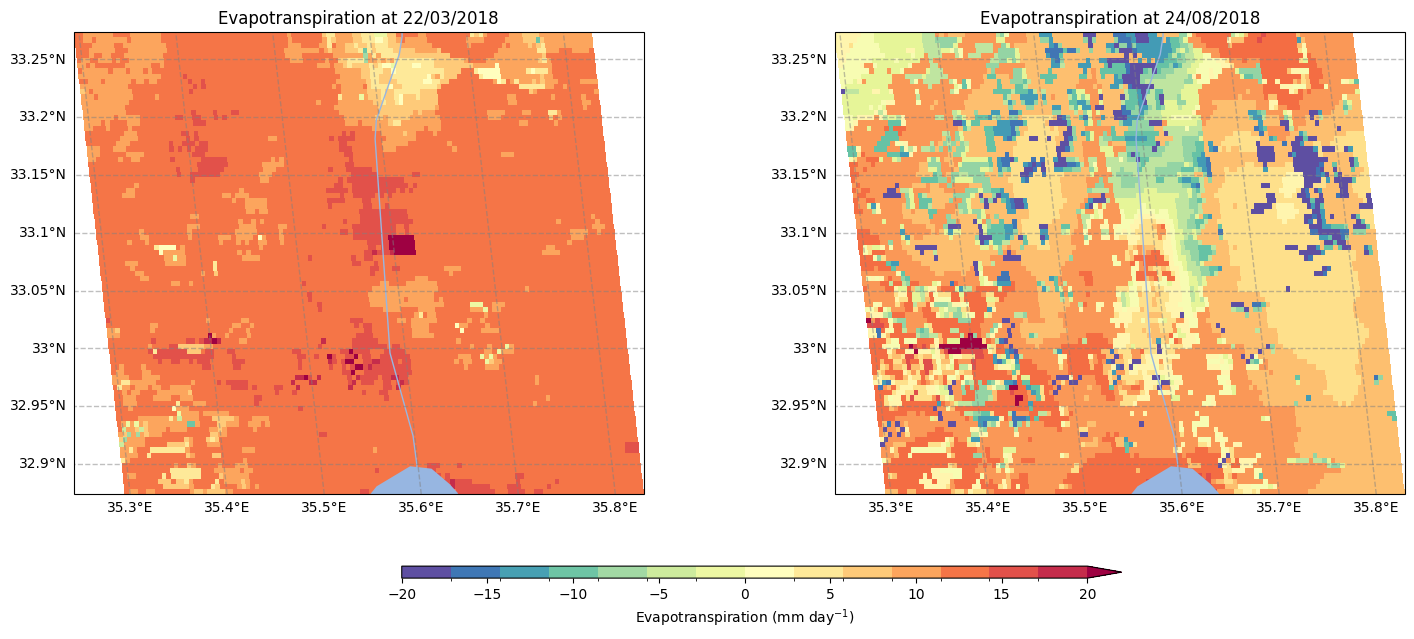

In [40]:
# We need to convert the units from W/m^2 to mm/day


def ET_calc(LE_array, temp):
  ro = 1000 # Kg/m^3
  lv = 3147.5 - 2.37 * (temp + 273)

  ET = (LE_array * 1000 * 86400) / (ro * lv * 10**3)

  # replace all extreme values with nan
  # ET = ET.where(ET > -20, np.nan)
  # ET = ET.where(ET < 20, np.nan)
  return ET


ET_08 = ET_calc(LE_08, 29.5) # temperature values taken from IMS station Zefat Har Kenaan
ET_03 = ET_calc(LE_03, 21.6) #  temperature values taken from IMS station Zefat Har Kenaan

ET_08 = crop_raster(ET_08)
ET_03 = crop_raster(ET_03)

calc_stats(ET_03, ET_08, 'Evapotranspiration')
present_rasters('Evapotranspiration', ET_08, ET_03, -20, 20, '(mm day$^{-1}$)')

sloppe 0.20944275682819477
intercept 0.7329271119455814

The linear regression equation is: y=0.21x + 0.73
The R-squared value is: 0.01


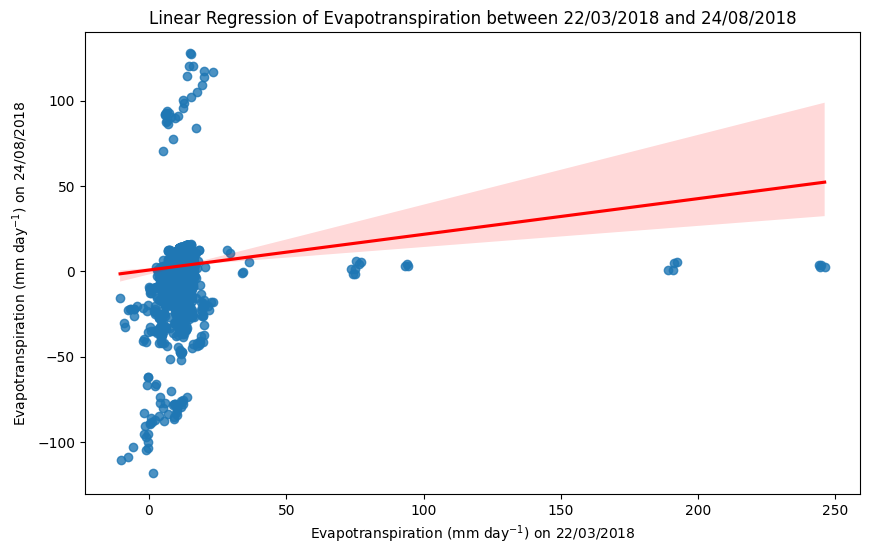

In [41]:
scatter_plot(ET_03, ET_08, 'Evapotranspiration', units='(mm day$^{-1}$)')

## Statistics and Comperisons - Before Cleaning

sloppe -0.028112876825807903
intercept 402.157118338841

The linear regression equation is: y=-0.03x + 402.16
The R-squared value is: 0.12


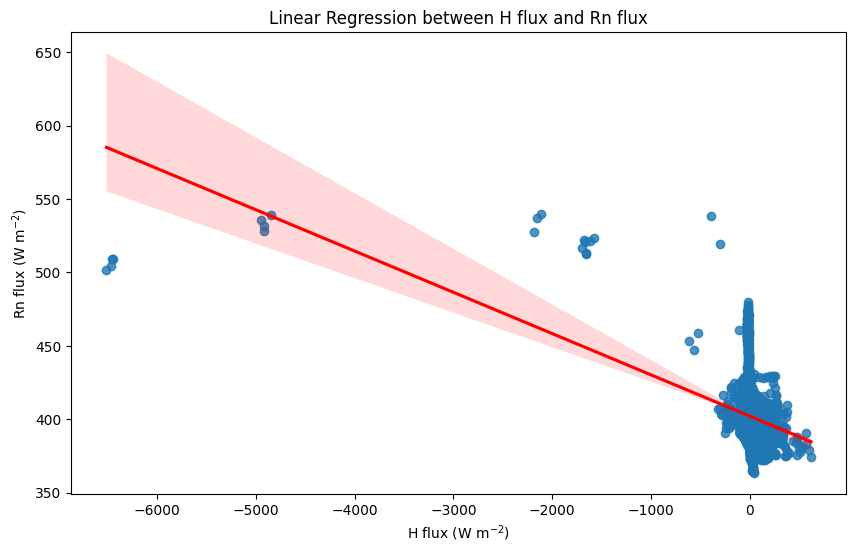

In [42]:
scatter_plot_diff_flux(H_03, Rn_03, 'H flux', 'Rn flux', '(W m$^{-2}$)', '(W m$^{-2}$)')

sloppe 0.35428353852598304
intercept -5.168122562939621

The linear regression equation is: y=0.35x + -5.17
The R-squared value is: 0.0


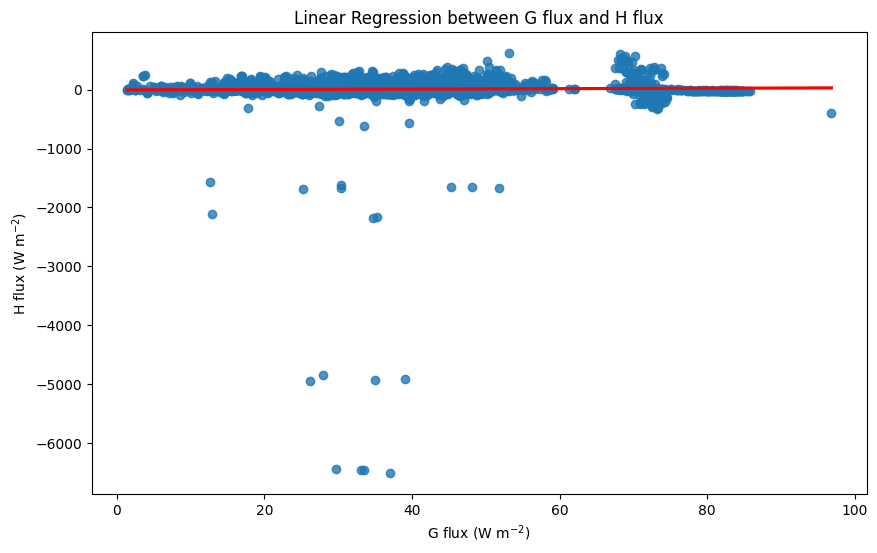

In [43]:
scatter_plot_diff_flux(G_03, H_03, 'G flux', 'H flux', '(W m$^{-2}$)', '(W m$^{-2}$)')

sloppe -0.007850124040605875
intercept 403.9975799693642

The linear regression equation is: y=-0.01x + 404.0
The R-squared value is: 0.04


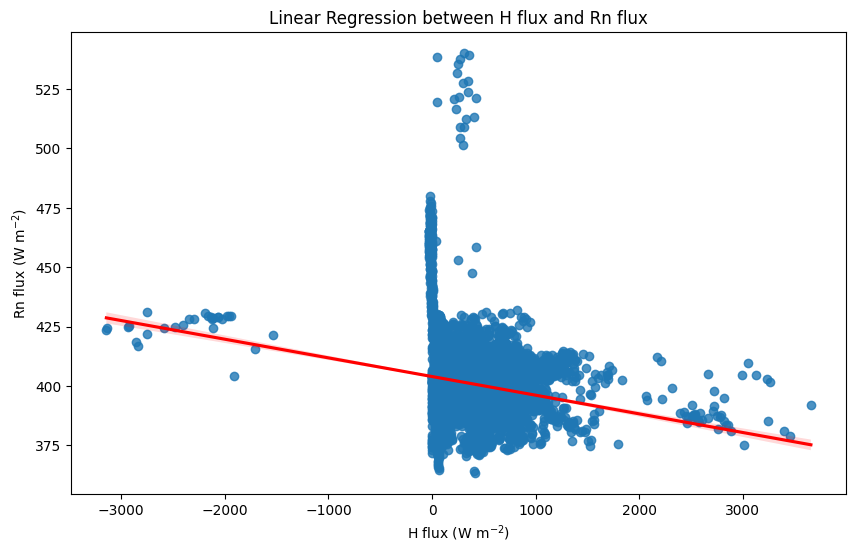

In [44]:
scatter_plot_diff_flux(H_08, Rn_03, 'H flux', 'Rn flux', '(W m$^{-2}$)', '(W m$^{-2}$)')

sloppe -27.25646329586306
intercept 350.8573193257872

The linear regression equation is: y=-27.26x + 350.86
The R-squared value is: 0.99


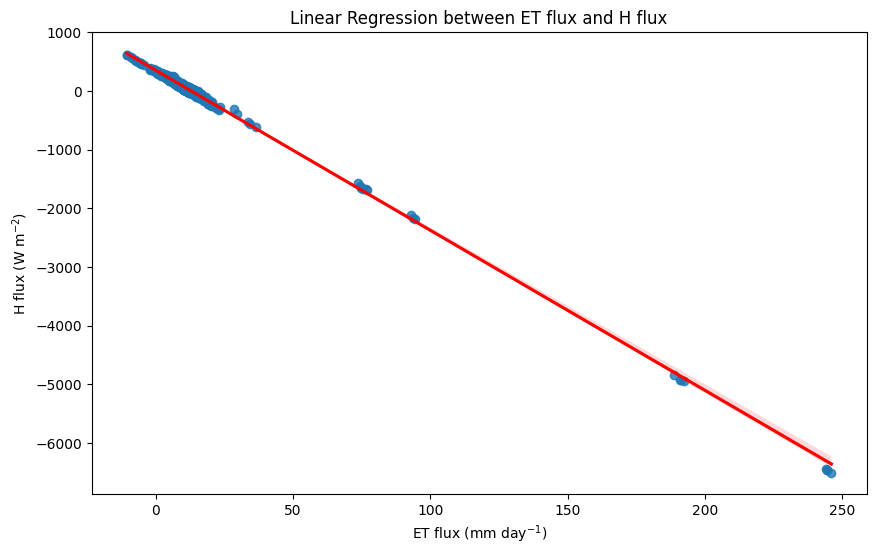

In [45]:
scatter_plot_diff_flux(ET_03, H_03, 'ET flux', 'H flux', '(mm day$^{-1}$)', '(W m$^{-2}$)')

# Deleting Extreme Values and Re-Analyze

The concept behind the following code is that the most significant flux, which affects the LE and the ET the most, is the sensible heat (H).  
removing the extreme values from H, was enough to create a reasonable ET output.
The main problem is that if we remove values from one dataset, then the dimensions won't fit to the other datasets, so a mask had to be applied to all dataset in the same way.

## Functions

In [46]:
def scatter_plot(array1, array2, name, units):
  import seaborn as sns
  import pandas as pd
  from scipy import stats

  # Convert DataArray to DataFrame
  df1 = array1.to_dataframe().reset_index()
  df2 = array2.to_dataframe().reset_index()


  # Merge the DataFrames on the common dimensions, if necessary
  df = pd.merge(df1, df2, on=['x', 'y'])
  # only leave the band data columns in df
  df = df[['band_data_x', 'band_data_y']]

  array1 = df['band_data_x'].to_numpy()
  array2 = df['band_data_y'].to_numpy()

  # removing nan values from the arrays
  combined_mask = ~np.isnan(array1) & ~np.isnan(array2)
  array1 = array1[combined_mask]
  array2 = array2[combined_mask]

  slope, intercept, r_value, p_value, std_err = stats.linregress(array1, array2)

  # calculating r squered
  r_squared = r_value**2

  # Print the results
  print(f'sloppe {slope}')
  print(f'intercept {intercept}')
  print(f'\nThe linear regression equation is: y={slope.round(2)}x + {intercept.round(2)}')
  print(f'The R-squared value is: {r_squared.round(2)}')

  # Plot using seaborn
  plt.figure(figsize=(10, 6))


  sns.regplot(x='band_data_x', y='band_data_y', data=df, line_kws={"color": "red"})

  plt.xlabel(f'{name} {units} on 22/03/2018')
  plt.ylabel(f'{name} {units} on 24/08/2018')
  plt.title(f'Linear Regression of {name} between 22/03/2018 and 24/08/2018')
  plt.savefig(path + 'output_plots/after_cleaning/' + name + '_scatter.png')
  plt.show()

In [47]:
def scatter_plot_diff_flux(array1, array2, name1, name2, units1, units2):
  import seaborn as sns
  import pandas as pd
  from scipy import stats

  # Convert DataArray to DataFrame
  df1 = array1.to_dataframe().reset_index()
  df2 = array2.to_dataframe().reset_index()


  # Merge the DataFrames on the common dimensions, if necessary
  df = pd.merge(df1, df2, on=['x', 'y'])

  array1 = df['band_data_x'].to_numpy()
  array2 = df['band_data_y'].to_numpy()

  # removing nan values from the arrays
  combined_mask = ~np.isnan(array1) & ~np.isnan(array2)
  array1 = array1[combined_mask]
  array2 = array2[combined_mask]

  slope, intercept, r_value, p_value, std_err = stats.linregress(array1, array2)

  # calculating r squered
  r_squared = r_value**2

  # Print the results
  print(f'sloppe {slope}')
  print(f'intercept {intercept}')
  print(f'\nThe linear regression equation is: y={slope.round(2)}x + {intercept.round(2)}')
  print(f'The R-squared value is: {r_squared.round(2)}')

  # Plot using seaborn
  plt.figure(figsize=(10, 6))

  sns.regplot(x='band_data_x', y='band_data_y', data=df, line_kws={"color": "red"})

  plt.xlabel(f'{name1} {units1}')
  plt.ylabel(f'{name2} {units2}')
  plt.title(f'Linear Regression between {name1} and {name2}')
  plt.savefig(path + 'output_plots/after_cleaning/' + name1 + '_' + name2 + '_scatter.png')
  plt.show()

In [48]:
# function that creates a histogram of the values for each raster
def histogram(raster, name):
    raster = raster.to_dataframe()['band_data']
    fig, ax = plt.subplots()
    sns.histplot(raster, ax=ax)
    ax.set_title(f'Histogram of {name}')
    ax.set_xlabel('Value (W/m^2')
    ax.set_ylabel('Frequency')
    plt.savefig(path + 'output_plots/' + name + '_histogram.png')
    plt.show()



## Removing Extreme Values

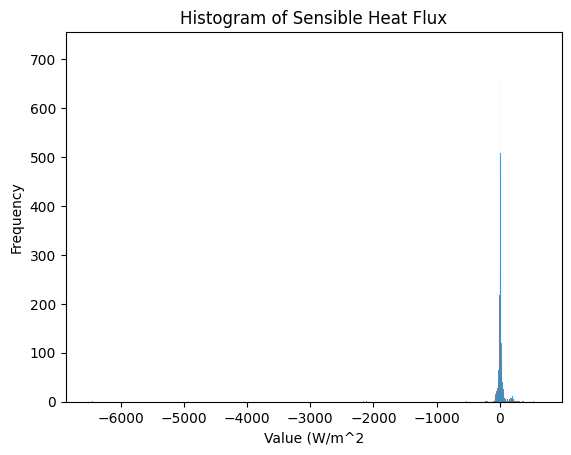

In [49]:
histogram(H_03, 'Sensible Heat Flux')

The following is the code where all datasets were masked into the same dimensions, and thus creating the option to do correlations tests between them.

In [50]:
min_threshold = -1000
max_threshold = -min_threshold

Rn_03 = Rn_03.where((H_03['band_data'] >= min_threshold) & (H_03['band_data'] <= max_threshold))
Rn_08 = Rn_08.where((H_08['band_data'] >= min_threshold) & (H_08['band_data'] <= max_threshold))

G_03 = G_03.where((H_03['band_data'] >= min_threshold) & (H_03['band_data'] <= max_threshold))
G_08 = G_08.where((H_08['band_data'] >= min_threshold) & (H_08['band_data'] <= max_threshold))

LE_03 = LE_03.where((H_03['band_data'] >= min_threshold) & (H_03['band_data'] <= max_threshold))
LE_08 = LE_08.where((H_08['band_data'] >= min_threshold) & (H_08['band_data'] <= max_threshold))

ET_03 = ET_03.where((H_03['band_data'] >= min_threshold) & (H_03['band_data'] <= max_threshold))
ET_08 = ET_08.where((H_08['band_data'] >= min_threshold) & (H_08['band_data'] <= max_threshold))

H_03 = H_03.where((H_03['band_data'] >= min_threshold) & (H_03['band_data'] <= max_threshold))
H_08 = H_08.where((H_08['band_data'] >= min_threshold) & (H_08['band_data'] <= max_threshold))


## Correlation Between Dates

Rn flux stats for the date 2018-03-22
mean: 401.76193523560084
median: 401.09246873509255
minimun value: 363.35105114483576
maximum value: 538.4276707833938

Rn flux stats for the date 2018-08-24
mean: 444.24743484301183
median: 441.4629539562858
minimun value: 399.5573589893164
maximum value: 539.6366668979549
sloppe 0.6175368249761397
intercept 196.10410029188978

The linear regression equation is: y=0.62x + 196.1
The R-squared value is: 0.14


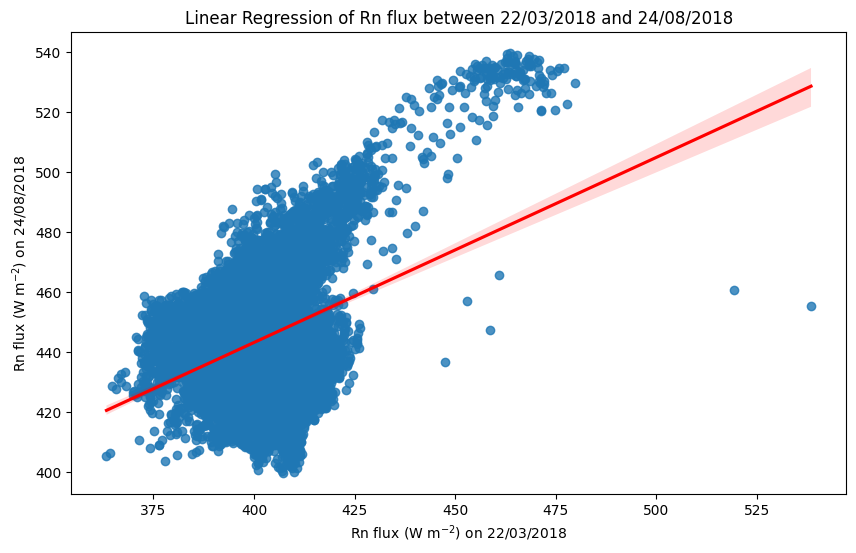

In [51]:
calc_stats(Rn_03, Rn_08, 'Rn flux')
scatter_plot(Rn_03, Rn_08, 'Rn flux', '(W m$^{-2}$)')

G flux stats for the date 2018-03-22
mean: 36.4051725648654
median: 37.13164482536601
minimun value: 1.358954011955929
maximum value: 96.8326851618729

G flux stats for the date 2018-08-24
mean: 78.27292526304454
median: 80.7802643129859
minimun value: 6.188894531494376
maximum value: 123.68721019020666
sloppe 0.24604107116255775
intercept 69.39687241556621

The linear regression equation is: y=0.25x + 69.4
The R-squared value is: 0.06


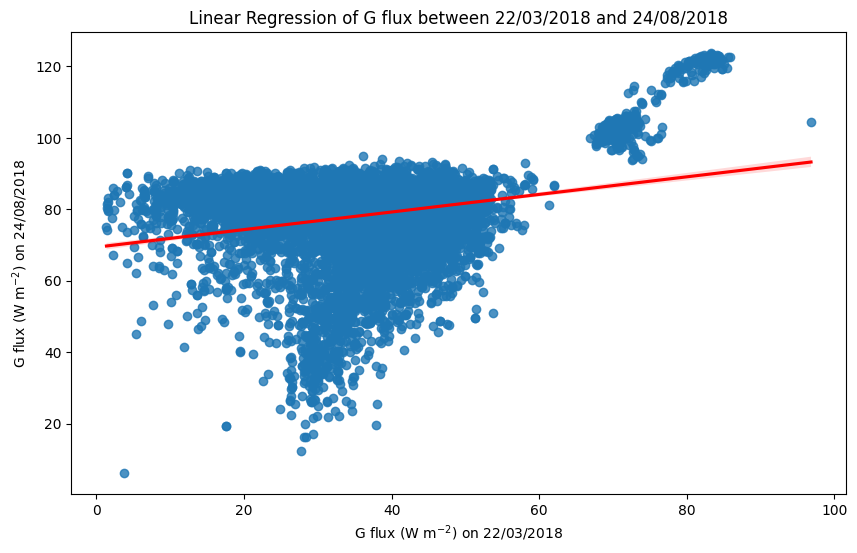

In [52]:
calc_stats(G_03, G_08, 'G flux')
scatter_plot(G_03, G_08, 'G flux', '(W m$^{-2}$)')

H flux stats for the date 2018-03-22
mean: 12.948473901947603
median: 5.209351802534247
minimun value: -616.4579020368355
maximum value: 619.2722703359785

H flux stats for the date 2018-08-24
mean: 236.81242251571678
median: 143.43138459451976
minimun value: -27.51980466209961
maximum value: 999.0790999751187
sloppe 1.3443659563521206
intercept 221.91734958648559

The linear regression equation is: y=1.34x + 221.92
The R-squared value is: 0.07


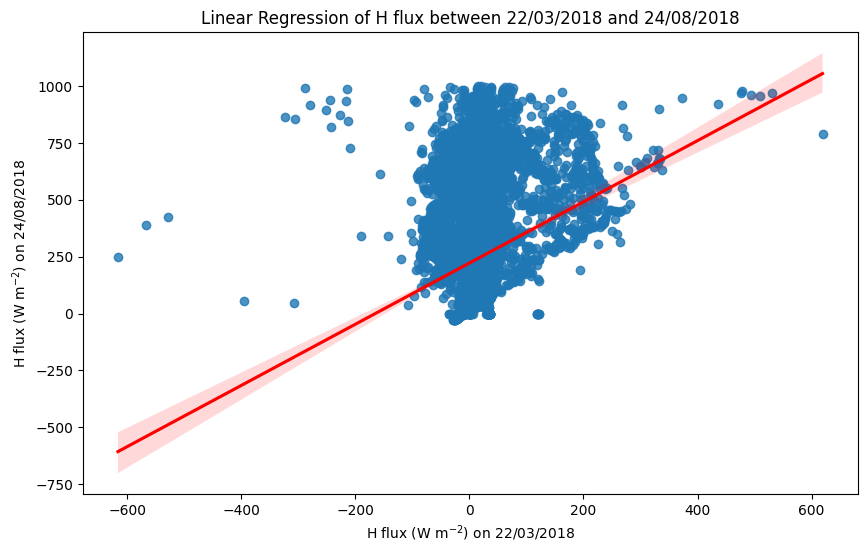

In [53]:
calc_stats(H_03, H_08, 'H flux')
scatter_plot(H_03, H_08, 'H flux', '(W m$^{-2}$)')

LE flux stats for the date 2018-03-22
mean: 351.11984713573577
median: 360.3624620427822
minimun value: -298.122703951926
maximum value: 1036.0075302043092

LE flux stats for the date 2018-08-24
mean: 124.72649610828759
median: 203.26855673391273
minimun value: -651.6624823114589
maximum value: 443.4001681824563
sloppe 1.11934852738596
intercept -270.9073191280411

The linear regression equation is: y=1.12x + -270.91
The R-squared value is: 0.07


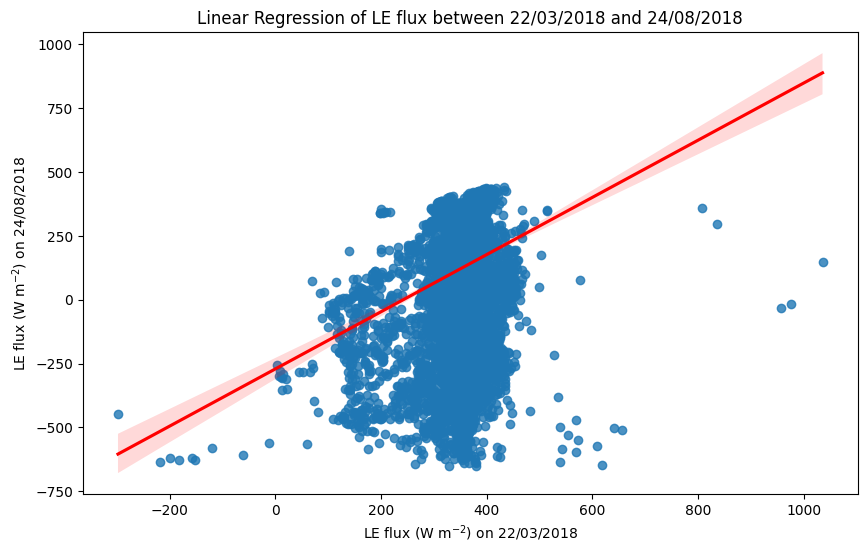

In [54]:
calc_stats(LE_03, LE_08, 'LE flux')
scatter_plot(LE_03, LE_08, 'LE flux', '(W m$^{-2}$)')

ET flux stats for the date 2018-03-22
mean: 12.367596552272724
median: 12.698586398019765
minimun value: -10.516401687931156
maximum value: 36.54559412927799

ET flux stats for the date 2018-08-24
mean: 4.299718383716356
median: 7.14633209590237
minimun value: -23.164740224724625
maximum value: 15.761609714147568
sloppe 1.0965382822298733
intercept -9.355222787156743

The linear regression equation is: y=1.1x + -9.36
The R-squared value is: 0.06


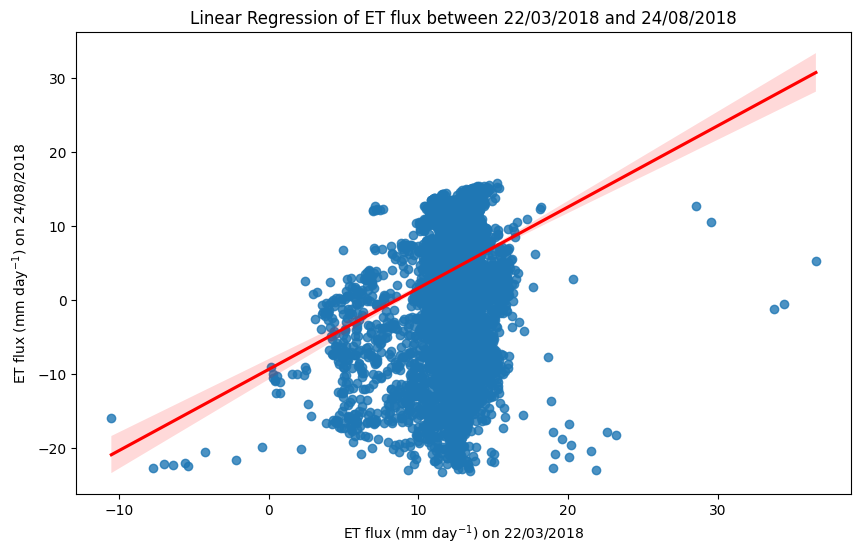

In [55]:
calc_stats(ET_03, ET_08, 'ET flux')
scatter_plot(ET_03, ET_08, 'ET flux', '(mm day$^{-1}$)')

In [56]:
rn_03_mean, rn_03_median, rn_03_min, rn_03_max, rn_08_mean, rn_08_median, rn_08_min, rn_08_max = calc_stats(Rn_03, Rn_08, 'Rn flux')
g_03_mean, g_03_median, g_03_min, g_03_max, g_08_mean, g_08_median, g_08_min, g_08_max = calc_stats(G_03, G_08, 'G flux')
h_03_mean, h_03_median, h_03_min, h_03_max, h_08_mean, h_08_median, h_08_min, h_08_max = calc_stats(H_03, H_08, 'H flux')
le_03_mean, le_03_median, le_03_min, le_03_max, le_08_mean, le_08_median, le_08_min, le_08_max = calc_stats(LE_03, LE_08, 'LE flux')
et_03_mean, et_03_median, et_03_min, et_03_max, et_08_mean, et_08_median, et_08_min, et_08_max = calc_stats(ET_03, ET_08, 'ET flux')

# creating a dataframe with the mean, median and range for each date and each flux

# first, we'll create a dictionary that will contain the mean, median and range for each flux for each date
data = {
    f'Statistic': ['Mean', 'Median', 'Minimum', 'Maximum'],
    f'Net Radiation 03 (W/m^2)': [rn_03_mean, rn_03_median, rn_03_min, rn_03_max],
    f'Net Radiation 08 (W/m^2)': [rn_08_mean, rn_08_median, rn_08_min, rn_08_max],
    f'Ground Heat 03 (W/m^2)': [g_03_mean, g_03_median, g_03_min, g_03_max],
    f'Ground Heat 08 (W/m^2)': [g_08_mean, g_08_median, g_08_min, g_08_max],
    f'Sensible Heat 03 (W/m^2)': [h_03_mean, h_03_median, h_03_min, h_03_max],
    f'Sensible Heat 08 (W/m^2)': [h_08_mean, h_08_median, h_08_min, h_08_max],
    f'Latent Heat 03 (W/m^2)': [le_03_mean, le_03_median, le_03_min, le_03_max],
    f'Latent Heat 08 (W/m^2)': [le_08_mean, le_08_median, le_08_min, le_08_max],
    f'Evapotranspiration 03 (mm/day)': [et_03_mean, et_03_median, et_03_min, et_03_max],
    f'Evapotranspiration 08 (mm/day)': [et_08_mean, et_08_median, et_08_min, et_08_max]
}

# converting the dictionary to a dataframe
df = pd.DataFrame(data)
# rounding all values
df = df.round(2)

df.set_index('Statistic', inplace=True)
df.T.to_csv(path + 'output_plots/fluxes_stats.csv')
df

Rn flux stats for the date 2018-03-22
mean: 401.76193523560084
median: 401.09246873509255
minimun value: 363.35105114483576
maximum value: 538.4276707833938

Rn flux stats for the date 2018-08-24
mean: 444.24743484301183
median: 441.4629539562858
minimun value: 399.5573589893164
maximum value: 539.6366668979549
G flux stats for the date 2018-03-22
mean: 36.4051725648654
median: 37.13164482536601
minimun value: 1.358954011955929
maximum value: 96.8326851618729

G flux stats for the date 2018-08-24
mean: 78.27292526304454
median: 80.7802643129859
minimun value: 6.188894531494376
maximum value: 123.68721019020666
H flux stats for the date 2018-03-22
mean: 12.948473901947603
median: 5.209351802534247
minimun value: -616.4579020368355
maximum value: 619.2722703359785

H flux stats for the date 2018-08-24
mean: 236.81242251571678
median: 143.43138459451976
minimun value: -27.51980466209961
maximum value: 999.0790999751187
LE flux stats for the date 2018-03-22
mean: 351.11984713573577
median:

Net Radiation 03 (W/m^2)  Net Radiation 08 (W/m^2)  \
Statistic                                                       
Mean                         401.76                    444.25   
Median                       401.09                    441.46   
Minimum                      363.35                    399.56   
Maximum                      539.64                    539.64   

           Ground Heat 03 (W/m^2)  Ground Heat 08 (W/m^2)  \
Statistic                                                   
Mean                        36.41                   78.27   
Median                      37.13                   80.78   
Minimum                      1.36                    6.19   
Maximum                    123.69                  123.69   

           Sensible Heat 03 (W/m^2)  Sensible Heat 08 (W/m^2)  \
Statistic                                                       
Mean                          12.95                    236.81   
Median                         5.21                    143.43   
Minimum                     -616.46                    -27.52   
Maximum                      999.08                    999.08   

           Latent Heat 03 (W/m^2)  Latent Heat 08 (W/m^2)  \
Statistic                                                   
Mean                       351.12                  124.73   
Median                     360.36                  203.27   
Minimum                   -298.12                 -651.66   
Maximum                    443.40                  443.40   

           Evapotranspiration 03 (mm/day)  Evapotranspiration 08 (mm/day)  
Statistic                                                                  
Mean                                12.37                            4.30  
Median                              12.70                            7.15  
Minimum                            -10.52                          -23.16  
Maximum                             15.76                           15.76

## Correlation Between Fluxes

sloppe 0.22199932835362196
intercept 5.2178386250083655

The linear regression equation is: y=0.22x + 5.22
The R-squared value is: 0.0


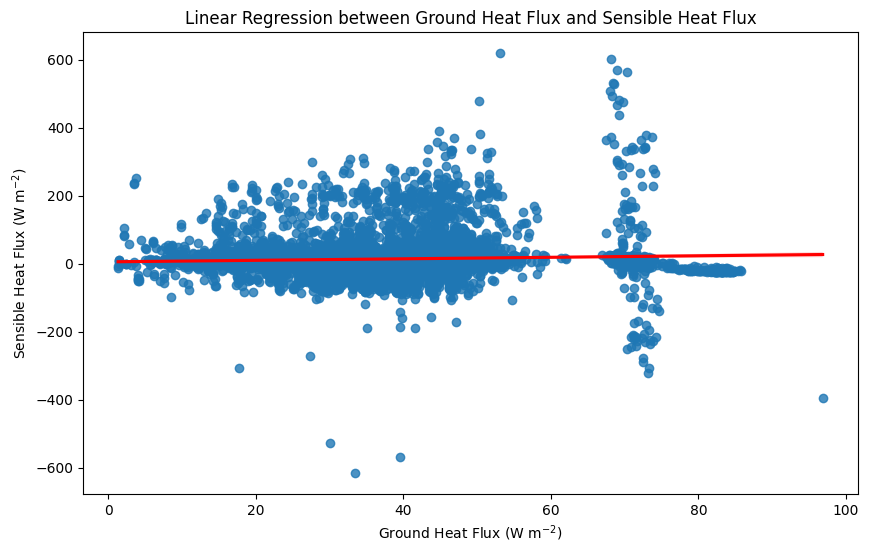

In [57]:
scatter_plot_diff_flux(G_03, H_03, 'Ground Heat Flux', 'Sensible Heat Flux', '(W m$^{-2}$)', '(W m$^{-2}$)')

sloppe -0.19265377536809306
intercept 113.72788721330467

The linear regression equation is: y=-0.19x + 113.73
The R-squared value is: 0.04


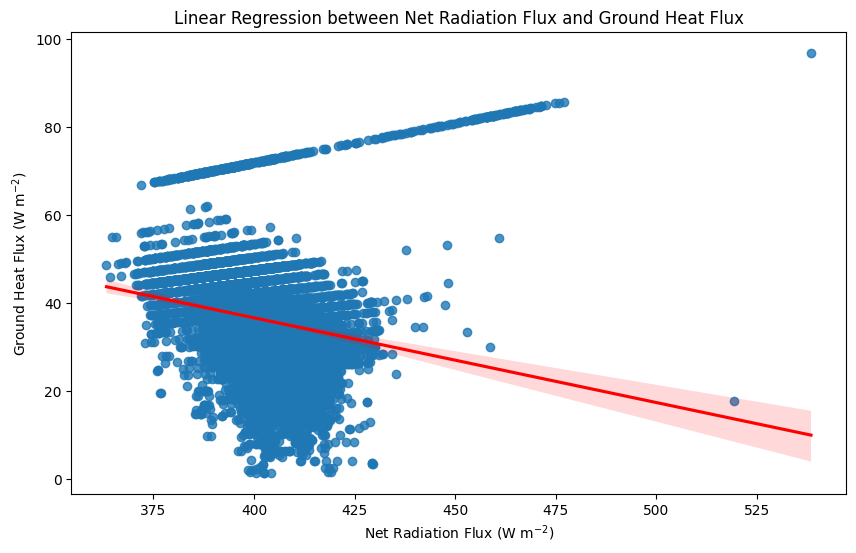

In [58]:
scatter_plot_diff_flux(Rn_03, G_03, 'Net Radiation Flux', 'Ground Heat Flux', '(W m$^{-2}$)', '(W m$^{-2}$)')

sloppe -0.05646957701687249
intercept 14.411903532921674

The linear regression equation is: y=-0.06x + 14.41
The R-squared value is: 0.1


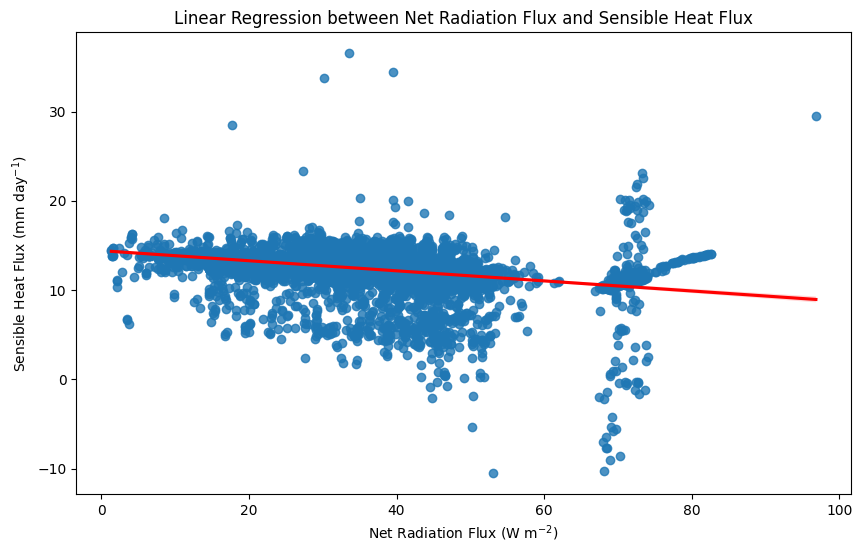

In [59]:
scatter_plot_diff_flux(G_03, ET_03, 'Net Radiation Flux', 'Sensible Heat Flux', '(W m$^{-2}$)', '(mm day$^{-1}$)')

sloppe 0.08236252492117745
intercept -20.62610886987087

The linear regression equation is: y=0.08x + -20.63
The R-squared value is: 0.19


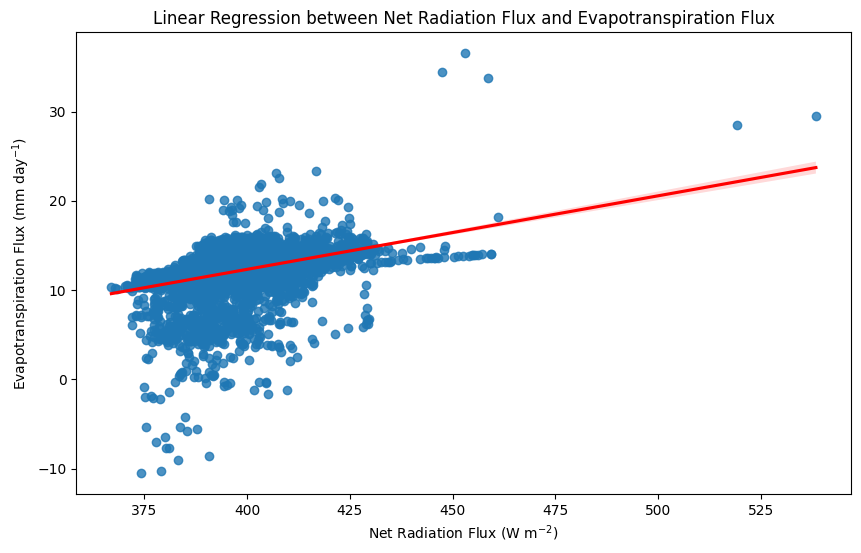

In [60]:
scatter_plot_diff_flux(Rn_03, ET_03, 'Net Radiation Flux', 'Evapotranspiration Flux', '(W m$^{-2}$)', '(mm day$^{-1}$)')

sloppe -0.8749721092014036
intercept 364.47896177187897

The linear regression equation is: y=-0.87x + 364.48
The R-squared value is: 0.05


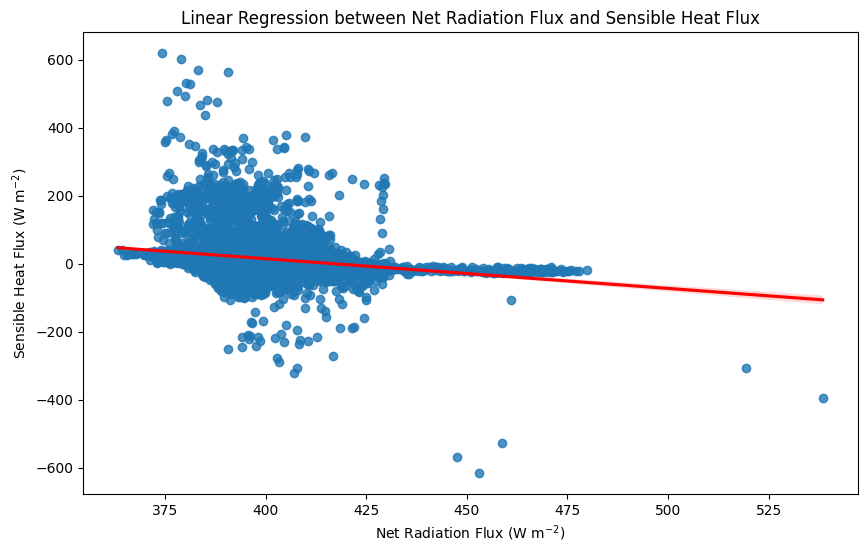

In [61]:
scatter_plot_diff_flux(Rn_03, H_03, 'Net Radiation Flux', 'Sensible Heat Flux', '(W m$^{-2}$)', '(W m$^{-2}$)')

sloppe -0.037214122326769086
intercept 12.880715273519986

The linear regression equation is: y=-0.04x + 12.88
The R-squared value is: 0.9


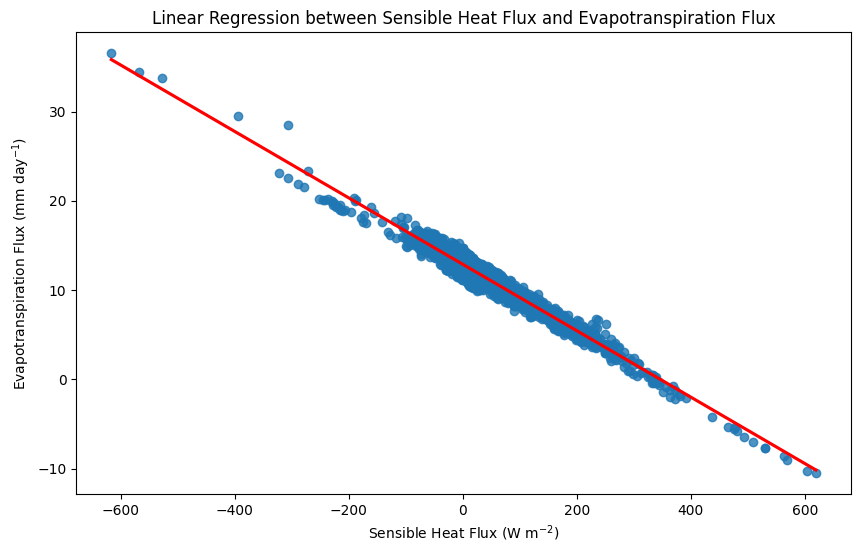

In [62]:
scatter_plot_diff_flux(H_03, ET_03, 'Sensible Heat Flux', 'Evapotranspiration Flux', '(W m$^{-2}$)', '(mm day$^{-1}$)')

sloppe -2.4704131529791113
intercept 432.04814540119474

The linear regression equation is: y=-2.47x + 432.05
The R-squared value is: 0.02


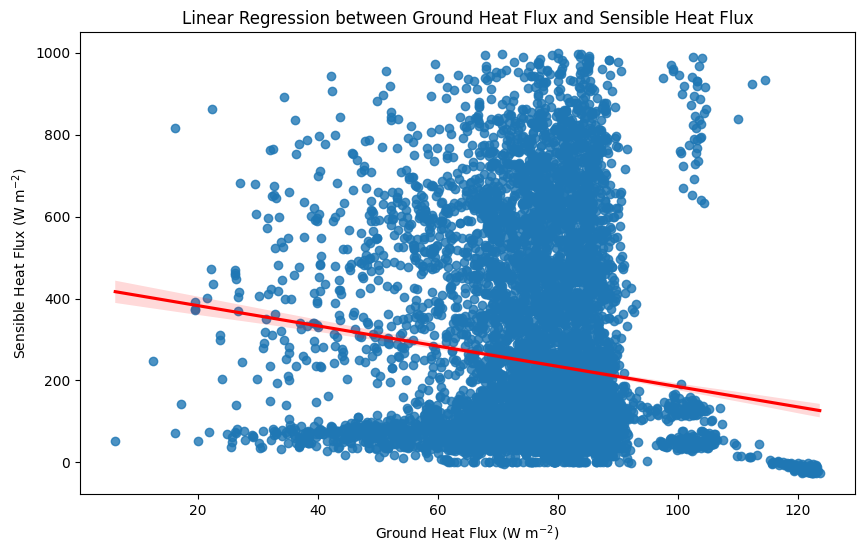

In [63]:
scatter_plot_diff_flux(G_08, H_08, 'Ground Heat Flux', 'Sensible Heat Flux', '(W m$^{-2}$)', '(W m$^{-2}$)')

sloppe -0.19856175493601036
intercept 166.43198524693645

The linear regression equation is: y=-0.2x + 166.43
The R-squared value is: 0.11


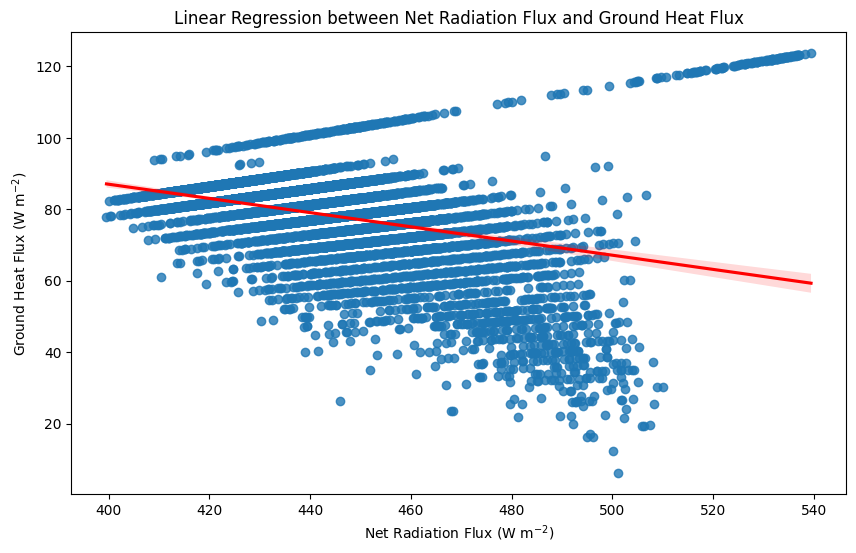

In [64]:
scatter_plot_diff_flux(Rn_08, G_08, 'Net Radiation Flux', 'Ground Heat Flux', '(W m$^{-2}$)', '(W m$^{-2}$)')

sloppe 0.008077801934540576
intercept 3.672972072023573

The linear regression equation is: y=0.01x + 3.67
The R-squared value is: 0.0


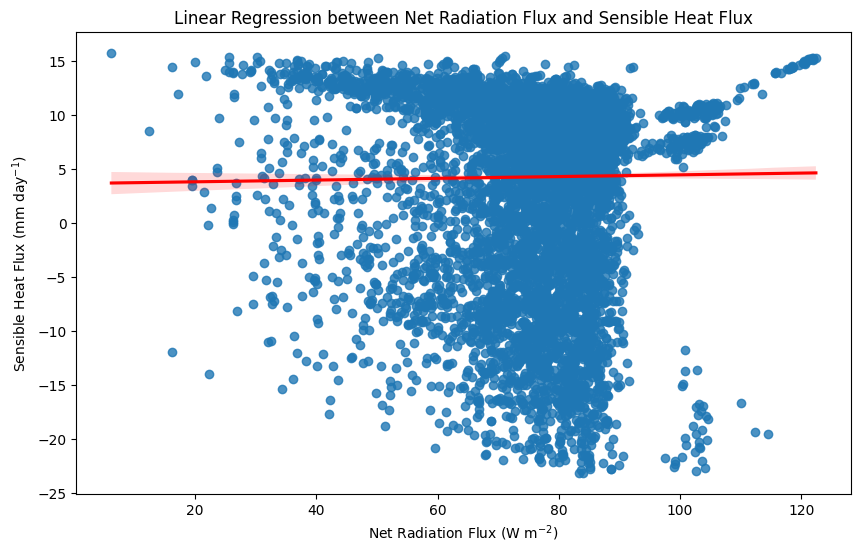

In [65]:
scatter_plot_diff_flux(G_08, ET_08, 'Net Radiation Flux', 'Sensible Heat Flux', '(W m$^{-2}$)', '(mm day$^{-1}$)')

sloppe 0.06135762972031538
intercept -22.916828990396453

The linear regression equation is: y=0.06x + -22.92
The R-squared value is: 0.02


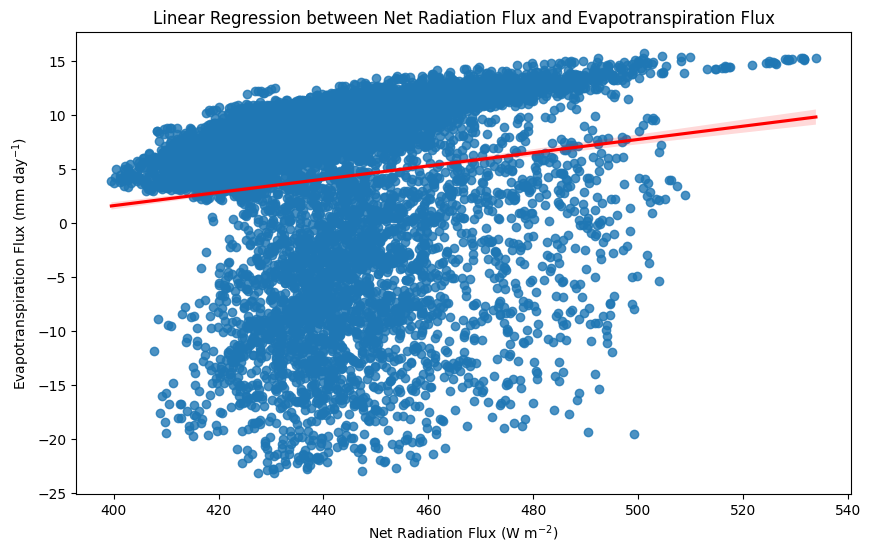

In [66]:
scatter_plot_diff_flux(Rn_08, ET_08, 'Net Radiation Flux', 'Evapotranspiration Flux', '(W m$^{-2}$)', '(mm day$^{-1}$)')

sloppe -1.0849284137214872
intercept 718.7890872997854

The linear regression equation is: y=-1.08x + 718.79
The R-squared value is: 0.01


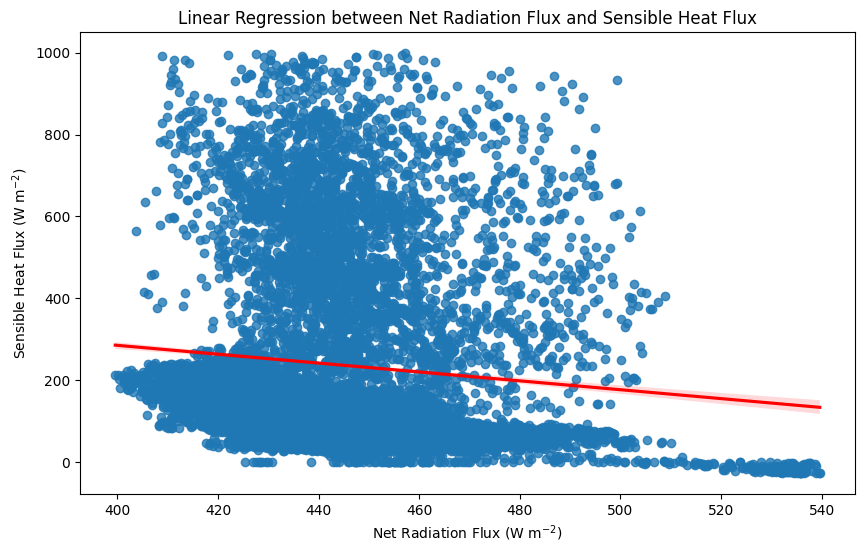

In [67]:
scatter_plot_diff_flux(Rn_08, H_08, 'Net Radiation Flux', 'Sensible Heat Flux', '(W m$^{-2}$)', '(W m$^{-2}$)')

sloppe -0.03545265549603861
intercept 12.986520372731285

The linear regression equation is: y=-0.04x + 12.99
The R-squared value is: 0.99


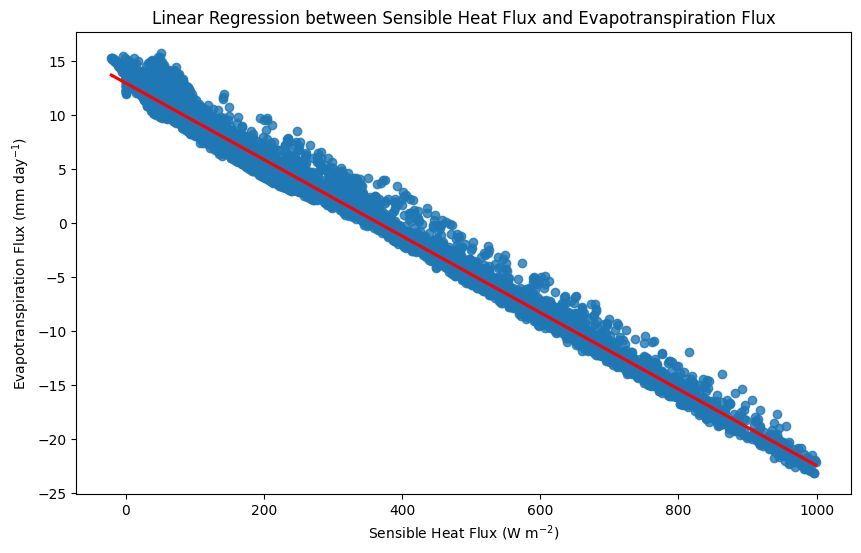

In [68]:
scatter_plot_diff_flux(H_08, ET_08, 'Sensible Heat Flux', 'Evapotranspiration Flux', '(W m$^{-2}$)', '(mm day$^{-1}$)')